# Measuring the progress of AI research

This notebook collects problems and metrics / datasets from the AI research literature, and tracks progress on them.
### Taxonomy

It collates data with the following structure:

```
problem 
    \   \
     \   metrics  -  measures 
      \
       - subproblems
            \
          metrics
             \
            measures
```

Problems should ideally be formulated in the form "software is able to learn to do X given training data of type Y". In some cases X is the interesting part, but sometimes also Y.

problems are tagged with attributes:
eg, vision, abstract-games, language, world-modelling, safety

Some of these are about performance relative to humans (which is of course a very arbitrary standard, but one we're familiar with)
* agi -- most capable humans can do this, so AGIs can do this (note it's conceivable that an agent might pass the Turing test before all of these are won)
* super -- the very best humans can do this, or human organisations can do this
* verysuper -- neither humans nor human orgs can presently do this

problems can have "subproblems", including simpler cases and preconditions for solving the problem in general

a "metric" is one way of measuring progress on a problem, commonly associated with a test dataset. There will often be several metrics
for a given problem, but in some cases we'll start out with zero metrics and will need to start proposing some...

a measure[ment] is a score on a given metric, by a particular codebase/team/project, at a particular time

In [372]:
from IPython.display import HTML ; HTML('''<script>code_show=false; function code_toggle() {if (code_show){$('div.input').hide();} else { $('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle); </script> <form action="javascript:code_toggle()"><input type="submit" value="Click here to hide/show source code."></form>''')

In [373]:
# Housekeeping code

from datetime import date
from lxml.html import fromstring
from math import log
from matplotlib import pyplot as plt
import matplotlib as mpl
import json
import re
import requests
import traceback

problems = {}
metrics = {}
measurements = set() # we don't try to guarantee unique names for these, so use a set
all_attributes = set()

class Problem:
    def __init__(self, name, attributes=[], solved=False, url=None):
        self.name = name
        self.attributes = attributes
        for a in attributes:
            global all_attributes
            all_attributes.add(a)
        self.subproblems = []
        self.superproblems = []
        self.metrics = []
        self.solved = solved
        self.url = url
        global problems, metrics
        problems[name] = self
        
    def subproblem(self, other_problem):
        self.superproblems.append(other_problem)
        other_problem.subproblems.append(self)
        
    def metric(self, *args, **kwargs):
        m = Metric(*args, **kwargs)
        m.parent = self
        self.metrics.append(m)
        return m
    
    def check_solved(self):
        if all(m.solved for m in self.metrics + self.subproblems):
            self.solved = True
            for p in self.superproblems:
                p.check_solved()


# Different metrics and measurements for progress are made on very different types of scales
# we have some helper functions to regularise these a little bit, so we can tell (for instance)
# whether progress on some metric appears to be accelerating or decelerating.

# Interface:
#    improvement(score1, score2): retrns a consistent measure of how much better score2 is than score1
#    pseudolinear(score): returns a modified version of score where we would expect vaguely linear progress

class Linear:
    def improvement(self, score1, score2):
        return score2 - score1
    def pseudolinear(self, score):
        return score
linear = Linear()

class ELO:
    def improvement(self, score1, score2):
        """
        Normalise an ELO score
        
        An ELO increase of 400 improves your odds by 10x, so we could justify something like
        return 10.0 ** ((score2 - score1)/400.)
        However, it seems that at least for chess ELO progress has been roughly linear over
        time, both for humans and computers (though with different coefficients). Perhaps this
        tracks exponential increases in ability to search the game's state space, driven directly
        by Moore's law on the computer side, and indirectly for humans by access to better training
        tools and more profound libraries of past play.
        
        So for now let's treat this as linear? But ELO is not a chess-specific measure, and in other
        contexts we may want to do exponentiation as documented above?
        """
        return score2 - score1
    def pseudolinear(self, score):
        return score
    
elo = ELO()

class ErrorRate:
    """Many labelling contests use these measures"""
    def improvement(self, score1, score2):
        # improvement is measured as a negative log of the error rate
        return log(score1) - log(score2)
    def pseudolinear(self, score):
        # The choice of base here is arbitrary. But since this is computer science, let's use base2!
        return log(score) / log(2.0)
error_rate = ErrorRate()

class CorrectRate:
    "100 - error rate"
    def erate(self, score):
        return (100. - score)/100.

    def improvement(self, score1, score2):
        return self.erate(score1) / self.erate(score2)
    
    def pseudolinear(self, score):
        from math import log
        return log(self.erate(score)) / log(2.0)
correct_rate = CorrectRate()

mpl.rcParams["legend.fontsize"] = u"x-small"
mpl.rcParams["xtick.labelsize"] = u"xx-small"
mpl.rcParams["ytick.labelsize"] = u"x-small"

class Metric:
    def __init__(self, name, url=None, solved=False, notes="", scale=linear, target=None, parent=None, changeable=False):
        self.name = name
        self.measures = []
        self.solved = solved
        self.url = url
        self.notes = notes
        self.scale = scale
        self.target = target
        self.changeable = changeable # True if a metric changes over time
        global metrics
        metrics[name] = self
        self.parent = parent
        
    def measure(self, *args, **kwargs):
        m = Measurement(*args, **kwargs)
        m.metric = self
        self.measures.append(m)
        if self.target:
            if self.scale.improvement(self.target, m.value) >= 0:
                self.solved = True
                self.parent.check_solved()
        return m
    
    def graph(self):
        plt.figure(dpi=300)
        #plt.figure(figsize=(8, 6), dpi=300)

        self.measures.sort(key=lambda m: (m.date, m.metric.scale.pseudolinear(m.value)))
        
        # scatter plot of results in the literature
        xs = [m.date for m in self.measures]
        ys = [m.value for m in self.measures]
        plt.plot_date(xs, ys)
        for n, m in enumerate(self.measures):
            plt.annotate('%s' % m.name, xy=(xs[n],ys[n]), xytext=(2,2), fontsize=6, textcoords='offset points')
        
        # line graph of the frontier of best results
        if not self.changeable:
            best = self.measures[0].value
            frontier_x, frontier_y = [], []
            for m in self.measures:
                if self.scale.improvement(best, m.value) >= 0:
                    frontier_x.append(m.date)
                    frontier_y.append(m.value)
                    xy = (m.date, m.value)       
                    best = m.value
            plt.plot_date(frontier_x, frontier_y, "g-")
        
        # dashed line for "solved" / strong human performance
        if self.target:
            if "agi" in self.parent.attributes:
                plt.plot_date([self.measures[0].date, self.measures[-1].date], 2 * [self.target], "r--", label="Human performance")
            else:
                plt.plot_date([self.measures[0].date, self.measures[-1].date], 2 * [self.target], "r--", label="target")
        plt.legend()
        plt.show()


class Measurement:
    def __init__(self, date, value, name, url, algorithms=[], uncertainty=0, minval=None, maxval=None, opensource=False, replicated="", papername=None):
        self.date = date
        self.value = value
        assert isinstance(value, float) or isinstance(value, int), "Measurements on metrics need to be numbers"
        self.name = name
        
        # For papers on arxiv, always use the abstract link rather than the PDF link
        if url.startswith("https://arxiv.org/pdf/"):
            url = url.replace("pdf", "abs", 1)
            url = url.replace(".pdf", "", 1)
        self.url = url

        self.minval = minval if minval else value - uncertainty
        self.maxval = maxval if maxval else value + uncertainty
        self.opensource = opensource
        self.replicated_url = replicated
        self.algorithms = []
        if papername is not None:
            self.papername = papername
        else:
            self.papername = pn.get_papername(url)
        global measurements
        measurements.add(self)

class PaperNames:
    def __init__(self):
        try:
            with open(".paper_cache.json") as f:
                self.cache = json.load(f)
        except:
            traceback.print_exc()
            print "(Continuing with an empty cache)"
            self.cache = {}
        self.arxiv_re = re.compile(r"\[[0-9v.]+\] (.*)")
        
    def get_papername(self, url):
        "Ask arxiv for a papername if we don't know it"
        if url in self.cache:
            return self.cache[url]
        req = requests.get(url)
        tree = fromstring(req.content)
        papername = tree.findtext('.//title')
        if papername:
            match = self.arxiv_re.match(papername)
            if match:
                papername = match.groups(0)[0]
        self.cache[url] = papername
        with open(".paper_cache.json", "w") as f:
            print "Caching paper name:", papername
            json.dump(self.cache, f, indent=4, sort_keys=True)
        return papername

pn = PaperNames()


### Sources to incorporate

* ☑ Jack Clark's collection of progress measurements 
* ☐ Sarah Constantin's [Performance Trends in AI](https://srconstantin.wordpress.com/2017/01/28/performance-trends-in-ai/)
* ☐ Katja Grace's [Algorithmic Progress in Six Domains](https://intelligence.org/files/AlgorithmicProgress.pdf)

In [374]:
# BEGIN ACTUALLY CLASSIFYING PROBLEMS

scene_description = Problem("Scene description", ["agi", "vision", "language", "world-modelling"])
image_classification = Problem("Image classification", ["vision", "agi"])
scene_description.subproblem(image_classification)

imagenet = image_classification.metric("imagenet", "http://image-net.org", scale=error_rate, target=0.051)
imagenet.notes = """
Correctly label images from the Imagenet dataset. As of 2016, this includes:
 - Object localization for 1000 categories.
 - Object detection for 200 fully labeled categories.
 - Object detection from video for 30 fully labeled categories.
 - Scene classification for 365 scene categories (Joint with MIT Places team) on Places2 Database http://places2.csail.mit.edu.
 - Scene parsing for 150 stuff and discrete object categories (Joint with MIT Places team).
WARNING: these subchallenges were added in successive years of the Imagenet challenge, so results from years are not directly
comparable; however progress should probably be understated by comparing them?
Note about the warning (Yomna): I think Jack said this wasn't a problem.
"""
imagenet.measure(date(2010,8,31), 0.28191, "NEC UIUC", "http://image-net.org/challenges/LSVRC/2010/results")
imagenet.measure(date(2011,10,26), 0.2577, "XRCE","http://image-net.org/challenges/LSVRC/2011/results")
imagenet.measure(date(2012,10,13), 0.16422, "SuperVision", "http://image-net.org/challenges/LSVRC/2012/results.html")
imagenet.measure(date(2013,11,14), 0.11743, "Clarifai","http://www.image-net.org/challenges/LSVRC/2013/results.php")
imagenet.measure(date(2014,8,18), 0.07405, "VGG", "http://image-net.org/challenges/LSVRC/2014/index")
imagenet.measure(date(2015,12,10), 0.03567, "MSRA", "http://image-net.org/challenges/LSVRC/2015/results", algorithms=["residual-networks"])
imagenet.measure(date(2016,9,26), 0.02991, "Trimps-Soushen", "http://image-net.org/challenges/LSVRC/2016/results")


<__main__.Measurement instance at 0x7f08f65745a8>

# Game Playing

In principle, games are a sufficiently open-ended framework that all of intelligence could be captured within them.

But abstract games like chess, go, checkers etc can be played with no knowldege of the human world or physics. Although this domain has largely been solved to super-human performance levels, there are a few ends that need to be tied up, especially in terms of having agents learn rules for arbitrary abstract games effectively given various plausible starting points (eg, textual descriptions of the rules or examples of correct play).

## Abstract Strategy Games

In [375]:
abstract_strategy_games = Problem("Abstract strategy games", ["agi", "abstract-games"])

playing_with_hints = Problem("Playing abstract games with extensive hints", ["abstract-games"], solved=True)
playing_with_hints.notes = """
  Complex abstract strategy games have been solved to super-human levels
  by computer systems with extensive rule-hinting and heuristics,
  in some cases combined with machine learning techniques.
"""
computer_chess = playing_with_hints.metric("computer chess", scale=elo, target=2881)
# For some caveats, see https://en.wikipedia.org/w/index.php?title=Chess_engine&oldid=764341963#Ratings
computer_chess.measure(date(2017,02,27), 3393, "Stockfish", uncertainty=50,
                           url="https://web.archive.org/web/20170227044521/http://www.computerchess.org.uk/ccrl/4040/")
computer_chess.measure(date(1997,05,11), 2725, "Deep Blue", uncertainty=25,
                           url="https://www.quora.com/What-was-Deep-Blues-Elo-rating")

mastering_historical_games = Problem("Mastering human abstract strategy games", ["super", "abstract-games"])
mastering_chess = mastering_historical_games.metric("mastering chess")
mastering_chess.notes = """
  Beating all humans at chess, given a corpus of past play amongst masters,
  but no human-crafted policy constraints and heuristics. This will probably fall out
  immediately once learning_abstract_game_rules is solved, since playing_with_hints
  has been solved.
"""

# Are there any published metrics for these yet?
learning_abstract_game_rules = Problem("Learning the rules of complex strategy games from examples", ["agi", "abstract-games"])
learning_chess = learning_abstract_game_rules.metric("learning chess")
learning_chess.notes = """
  Chess software contains hard-coded policy constraints for valid play; this metric is whether RL
  or other agents can correctly build those policy constraints from examples or oracles"""
learning_go = learning_abstract_game_rules.metric("learning go")
learning_go.notes = """
  Go software contains policy constraints for valid play and evaluating the number of
  liberties for groups. This metric is whether RL or other agents can correctly build those 
  policy constraints from examples or oracles"""
learning_arbitrary_abstract_games = Problem("Play an arbitrary abstract game, first learning the rules", ["agi", "abstract-games"])
                           


In [376]:
# Atari 2600 Games: Breakout, Enduro, Pong, Q*Bert, Seaquest, S. Invaders. Each game has its own metric.
# TODO: do the metrics for these games have

atari_games = Problem("Atari 2600 Games", ["curiosity", "world-modelling", "realtime-games"]) 

breakout = Problem("Breakout")
atari_games.subproblem(breakout)
breakout_metric = breakout.metric("Breakout", scale=linear)
breakout_metric.measure(date(2013,12,19), 225, "Playing Atari with Deep Reinforcement Learning", "https://arxiv.org/pdf/1312.5602.pdf")
breakout_metric.measure(date(2015,2,26), 401, "Human-level control through deep reinforcement learning", "https://www.semanticscholar.org/paper/Human-level-control-through-deep-reinforcement-Mnih-Kavukcuoglu/340f48901f72278f6bf78a04ee5b01df208cc508")
breakout_metric.measure(date(2015,10,22), 375, "Deep reinforcement learning with double q-learning", "https://pdfs.semanticscholar.org/3b97/32bb07dc99bde5e1f9f75251c6ea5039373e.pdf")
breakout_metric.measure(date(2015,11,20), 345, "Dueling Network Architectures for Deep Reinforcement Learning", "https://pdfs.semanticscholar.org/13b5/8f3108709dbbed5588759bc0496f82a261c4.pdf")
breakout_metric.measure(date(2016,6,16), 766.8, "Asynchronous Methods for Deep Reinforcement Learning", "https://arxiv.org/pdf/1602.01783.pdf")

enduro = Problem("Enduro")
atari_games.subproblem(enduro)
enduro_metric = enduro.metric("Enduro", scale=linear)
enduro_metric.measure(date(2013,12,19), 661, "Playing Atari with Deep Reinforcement Learning", "https://arxiv.org/pdf/1312.5602.pdf")
enduro_metric.measure(date(2015,2,26), 301, "Human-level control through deep reinforcement learning", "https://www.semanticscholar.org/paper/Human-level-control-through-deep-reinforcement-Mnih-Kavukcuoglu/340f48901f72278f6bf78a04ee5b01df208cc508")
enduro_metric.measure(date(2015,10,22), 319, "Deep reinforcement learning with double q-learning", "https://pdfs.semanticscholar.org/3b97/32bb07dc99bde5e1f9f75251c6ea5039373e.pdf")
enduro_metric.measure(date(2015,11,20), 2258, "Dueling Network Architectures for Deep Reinforcement Learning", "https://pdfs.semanticscholar.org/13b5/8f3108709dbbed5588759bc0496f82a261c4.pdf")
enduro_metric.measure(date(2016,6,16), 82.5, "Asynchronous Methods for Deep Reinforcement Learning", "https://arxiv.org/pdf/1602.01783.pdf")

pong = Problem("Pong")
atari_games.subproblem(pong)
pong_metric = pong.metric("Pong", scale=linear)
pong_metric.measure(date(2013,12,19), 21, "Playing Atari with Deep Reinforcement Learning", "https://arxiv.org/pdf/1312.5602.pdf")
pong_metric.measure(date(2015,2,26), 18.9, "Human-level control through deep reinforcement learning", "https://www.semanticscholar.org/paper/Human-level-control-through-deep-reinforcement-Mnih-Kavukcuoglu/340f48901f72278f6bf78a04ee5b01df208cc508")
pong_metric.measure(date(2015,10,22), 21, "Deep reinforcement learning with double q-learning", "https://pdfs.semanticscholar.org/3b97/32bb07dc99bde5e1f9f75251c6ea5039373e.pdf")
pong_metric.measure(date(2015,11,20), 21, "Dueling Network Architectures for Deep Reinforcement Learning", "https://pdfs.semanticscholar.org/13b5/8f3108709dbbed5588759bc0496f82a261c4.pdf?_ga=1.123524811.1334652001.1475539859")
pong_metric.measure(date(2016,6,16), 10.7, "Asynchronous Methods for Deep Reinforcement Learning", "https://arxiv.org/pdf/1602.01783.pdf")

q_bert = Problem("Q*Bert")
atari_games.subproblem(q_bert)
q_bert_metric = pong.metric("Pong", scale=linear)
q_bert_metric.measure(date(2013,12,19), 4500, "Playing Atari with Deep Reinforcement Learning", "https://arxiv.org/pdf/1312.5602.pdf")
q_bert_metric.measure(date(2015,2,26), 10596, "Human-level control through deep reinforcement learning", "https://www.semanticscholar.org/paper/Human-level-control-through-deep-reinforcement-Mnih-Kavukcuoglu/340f48901f72278f6bf78a04ee5b01df208cc508")
q_bert_metric.measure(date(2015,10,22), 14875, "Deep reinforcement learning with double q-learning", "https://pdfs.semanticscholar.org/3b97/32bb07dc99bde5e1f9f75251c6ea5039373e.pdf")
q_bert_metric.measure(date(2015,11,20), 19220, "Dueling Network Architectures for Deep Reinforcement Learning", "https://pdfs.semanticscholar.org/13b5/8f3108709dbbed5588759bc0496f82a261c4.pdf")
q_bert_metric.measure(date(2016,6,16), 21307, "Asynchronous Methods for Deep Reinforcement Learning", "https://arxiv.org/pdf/1602.01783.pdf")

seaquest = Problem("Seaquest")
atari_games.subproblem(seaquest)
seaquest_metric = pong.metric("Pong", scale=linear)
seaquest_metric.measure(date(2013,12,19), 1740, "Playing Atari with Deep Reinforcement Learning", "https://arxiv.org/pdf/1312.5602.pdf")
seaquest_metric.measure(date(2015,2,26), 5286, "Human-level control through deep reinforcement learning", "https://www.semanticscholar.org/paper/Human-level-control-through-deep-reinforcement-Mnih-Kavukcuoglu/340f48901f72278f6bf78a04ee5b01df208cc508")
seaquest_metric.measure(date(2015,10,22), 7995, "Deep reinforcement learning with double q-learning", "https://pdfs.semanticscholar.org/3b97/32bb07dc99bde5e1f9f75251c6ea5039373e.pdf?_ga=1.165640319.1334652001.1475539859")
seaquest_metric.measure(date(2015,11,20), 50254, "Dueling Network Architectures for Deep Reinforcement Learning", "https://pdfs.semanticscholar.org/13b5/8f3108709dbbed5588759bc0496f82a261c4.pdf?_ga=1.123524811.1334652001.1475539859")
seaquest_metric.measure(date(2016,6,16), 1326.1, "Asynchronous Methods for Deep Reinforcement Learning", "https://arxiv.org/pdf/1602.01783.pdf")

space_invaders = Problem("Space Invaders")
atari_games.subproblem(space_invaders)
space_invaders_metric = pong.metric("Pong", scale=linear)
space_invaders_metric.measure(date(2013,12,19), 1075, "Playing Atari with Deep Reinforcement Learning", "https://arxiv.org/pdf/1312.5602.pdf")
space_invaders_metric.measure(date(2015,2,26), 1976, "Human-level control through deep reinforcement learning", "https://www.semanticscholar.org/paper/Human-level-control-through-deep-reinforcement-Mnih-Kavukcuoglu/340f48901f72278f6bf78a04ee5b01df208cc508")
space_invaders_metric.measure(date(2015,10,22), 3154, "Deep reinforcement learning with double q-learning", "https://pdfs.semanticscholar.org/3b97/32bb07dc99bde5e1f9f75251c6ea5039373e.pdf?_ga=1.165640319.1334652001.1475539859")
space_invaders_metric.measure(date(2015,11,20), 6427, "Dueling Network Architectures for Deep Reinforcement Learning", "https://pdfs.semanticscholar.org/13b5/8f3108709dbbed5588759bc0496f82a261c4.pdf?_ga=1.123524811.1334652001.1475539859")
space_invaders_metric.measure(date(2016,6,16), 23846, "Asynchronous Methods for Deep Reinforcement Learning", "https://arxiv.org/pdf/1602.01783.pdf")



<__main__.Measurement instance at 0x7f08ef5b9e60>

## Real-time video games

In [377]:
# Speech recognition

"""
        http://melodi.ee.washington.edu/s3tp/

* * *
**_Word error rate on Switchboard (specify details): [Month, Year: Score [SWB]: Team].  Compiled by Jack Clark._**

A note about measurement: We're measuring Switchboard (SWB) and Call Home (CH) performance from the Hub5'00 dataset, with main scores assesses in terms of word error rate on SWB. We also create 

Why do we care: Reflects the improvement of audio processing systems on speech over time.

"""
speech_recognition = Problem(name="Speech Recognition", attributes=["language", "agi"])
switchboard_metric = speech_recognition.metric(name="Word error rate on Switchboard",
                                               scale=error_rate, target=5.9)
switchboard_metric.measure(date=date(2011,8,31), value=16.1,
                           name="Conversational Speech Transcription Using Context-Dependent Neural Networks",
                           url="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/CD-DNN-HMM-SWB-Interspeech2011-Pub.pdf")
switchboard_metric.measure(date=date(2012,4,27), value=18.5,
                           name="Deep Neural Networks for Acoustic Modeling in Speech Recognition",
                           url="https://pdfs.semanticscholar.org/ce25/00257fda92338ec0a117bea1dbc0381d7c73.pdf?_ga=1.195375081.452266805.1483390947")
switchboard_metric.measure(date=date(2013,8,25), value=12.9,
                           name="Sequence discriniative training of deep neural networks",
                           url="http://www.danielpovey.com/files/2013_interspeech_dnn.pdf")
switchboard_metric.measure(date=date(2014,6,30), value=16, 
                           name="Increasing Deep Neural Network Acoustic Model Size for Large Vocabulary Continuous Speech Recognition",
                           url="https://arxiv.org/abs/1406.7806v1")
switchboard_metric.measure(date=date(2014,12,7), value=20,
                           name="Deep Speech", url="https://arxiv.org/abs/1412.5567")
switchboard_metric.measure(date=date(2014,12,7), value=12.6,
                           name="Deep Speech", url="https://arxiv.org/abs/1412.5567")
switchboard_metric.measure(date=date(2015,5,21), value=8.0,
                           name="The IBM 2015 English Conversational Telephone Speech Recognition System",
                           url="https://arxiv.org/abs/1505.05899")
switchboard_metric.measure(date=date(2016,4,27), value=6.9,
                           name="The IBM 2016 English Conversational Telephone Speech Recognition System",
                           url="https://arxiv.org/abs/1604.08242v1")
switchboard_metric.measure(date=date(2017,2,17), value=6.9,
                           name="Microsoft 2016 Conversational Speech Recognition System",
                           url="https://arxiv.org/abs/1609.03528")
switchboard_metric.measure(date=date(2017,2,17), value=6.2,
                           name="Microsoft 2016 Conversational Speech Recognition System",
                           url="https://arxiv.org/abs/1609.03528")
switchboard_metric.measure(date=date(2016,10,17), value=6.6,
                           name="Achieving Human Parity in Conversational Speech Recognition",
                           url="https://arxiv.org/abs/1610.05256")
switchboard_metric.measure(date=date(2016,10,17), value=5.9,
                           name="Achieving Human Parity in Conversational Speech Recognition",
                           url="https://arxiv.org/abs/1610.05256")

<__main__.Measurement instance at 0x7f08ef68a4d0>

In [378]:
# Image Generation

""" 
* * *
**_Generative models of CIFAR-10 Natural Images _****[Year: bits-per-subpixel, method]. Compiled by Durk Kingma.**

**Why we care:**
(1) The compression=prediction=understanding=intelligence view (see Hutter prize, etc.). (Note that perplexity, log-likelihood, and #bits are all equivalent measurements.)
(2) Learning a generative model is a prominent auxiliary task towards semi-supervised learning. Current SOTA semi-supervised classification results utilize generative models.
3) You're finding patterns in the data that let you compress it more efficiently. Ultimate pattern recognition benchmark because you're trying to find the patterns in all the data. 

"""

image_generation = Problem("Generative models of CIFAR-10 Natural Images", ["vision", "agi"])
# note: this section is not on scene generation, but making the distinction seemed like a good idea.
scene_generation = Problem("Be able to generate complex scene e.g. a baboon receiving their degree at convocatoin.", ["vision", "world-modelling", "agi"])
scene_generation.subproblem(image_generation)

# NOTE: scale, and target need to be checked
image_generation_metric = image_generation.metric(name="bits-per-subpixel", scale=error_rate, target=1.0)

image_generation_metric.measure(date=date(2014,10,30), value=4.48, name="NICE", url="https://arxiv.org/abs/1410.8516")
image_generation_metric.measure(date=date(2015,2,16), value=4.13, name="DRAW", url="https://arxiv.org/abs/1502.04623")
image_generation_metric.measure(date=date(2016,5,27), value=3.49, name="Real NVP", url="https://arxiv.org/abs/1605.08803")
image_generation_metric.measure(date=date(2016,6,15), value=3.11, name="VAE with IAF", url="https://papers.nips.cc/paper/6581-improved-variational-inference-with-inverse-autoregressive-flow")
image_generation_metric.measure(date=date(2016,5,27), value=3.0, name="PixelRNN", url="https://arxiv.org/abs/1605.08803")
image_generation_metric.measure(date=date(2016,11,4), value=2.92, name="PixelCNN++", url="https://openreview.net/forum?id=BJrFC6ceg")


<__main__.Measurement instance at 0x7f08ef4852d8>

# Language Modelling and Comprehension

Text compression is one way to see how well machine learning systems are able to model human language. Shannon's [classic 1951 paper]() obtained an expiermental measure of human text compression performance at 0.6 - 1.3 bits per character: humans know, better than classic algorithms, what word is likely to come next in a piece of writing. More recent work ([Moradi 1998](https://pdfs.semanticscholar.org/48bc/ce35ceb72068723d5f360f388a073aadadca.pdf), Cover 1978) provides estimates that are text-relative and in the 1.3 bits per character (and for some texts, much higher) range.

In [379]:

penn_treebank_perplexity = Problem("A sense of how well computers can model language.", ["language", "agi"])
perplexity = penn_treebank_perplexity.metric(name="Treebank Perplexity", scale=error_rate, target=1)
perplexity.measure(date(2016,10,27), 66, "Recurrent Highway Networks", "https://arxiv.org/pdf/1607.03474v3")
perplexity.measure(date(2016,9,26), 70.9, "pointer sentinel-lstm", "https://arxiv.org/pdf/1609.07843v1.pdf")
perplexity.measure(date(2016,10,5), 73.4, "variational LSTM (large, untied, MC)", "https://arxiv.org/pdf/1512.05287v5.pdf")
perplexity.measure(date(2014,10,8), 82.2, " Recurrent Neural Network Regularization", "https://arxiv.org/abs/1409.2329")
perplexity.measure(date(2013,12,20), 107.5, "how to construct deep RNNs", "https://arxiv.org/abs/1312.6026")
perplexity.measure(date(2012,12,2), 124.7, "CONTEXT DEPENDENT RECURRENT NEURAL NETWORK LANGUAGE MODEL", "https://pdfs.semanticscholar.org/04e0/fefb859f4b02b017818915a2645427bfbdb2.pdf")

<__main__.Measurement instance at 0x7f08ef48ec68>

In [380]:
hutter_prize_compression = Problem("Bits-per-character on enwik8 dataset to measure Hutter Prize compression progression.\
                                   Why we care about this: relationship between compression and intelligence?", 
                                   ["compression"])
hp_compression = hutter_prize_compression.metric(name="hutter prize bits-per-character", scale=error_rate, target=1.3)
hp_compression.measure(date(2016,10,31), 1.313, "surprisal driven zoneout",
                   "https://pdfs.semanticscholar.org/e9bc/83f9ff502bec9cffb750468f76fdfcf5dd05.pdf")
hp_compression.measure(date(2016,10,19), 1.37, "surprisal-driven feedback in recurrent neural networks",
                   "https://arxiv.org/pdf/1608.06027.pdf")
hp_compression.measure(date(2016,9,27), 1.39, "Hypernetworks", "https://arxiv.org/abs/1609.09106")
hp_compression.measure(date(2016,9,6), 1.32, " Hierarchical Multiscale Recurrent Neural Networks", "https://arxiv.org/abs/1609.01704")
hp_compression.measure(date(2016,7,12), 1.32, "Recurrent highway networks", "https://arxiv.org/abs/1607.03474")
hp_compression.measure(date(2015,7,6), 1.47, "Grid Long Short-Term Memory", "https://arxiv.org/abs/1507.01526")
hp_compression.measure(date(2015,2,15), 1.58, "Gated Feedback Recurrent Neural Networks", "https://arxiv.org/abs/1502.02367")
# we need to match/double check the release date of the specific version of cmix that got this performance?
# hp_compression.measure(date(2014,4,13), 1.245, "cmix", "http://www.byronknoll.com/cmix.html")
hp_compression.measure(date(2013,8,4), 1.67, "Generating sequences with recurrent neural networks", "https://arxiv.org/abs/1308.0850")
hp_compression.measure(date(2011,6,28), 1.60, "Generating text with recurrent neural networks", "http://www.cs.utoronto.ca/~ilya/pubs/2011/LANG-RNN.pdf")

<__main__.Measurement instance at 0x7f08ef5b5170>

In [381]:
# Also consider adding the Microsoft Sentence Completion Challenge; see eg http://www.fit.vutbr.cz/~imikolov/rnnlm/thesis.pdf table 7.4


In [382]:
reading_comprehension = Problem("Language comprehension and question-answering", ["language", "world-modelling", "agi"])

bAbi = reading_comprehension.metric("bAbi", url="http://fb.ai/babi", scale=correct_rate, target=99)
bAbi.notes = """
A synthetic environment inspired by text adventures and SHRDLU, which enables generation
of ground truths, describing sentences, and inferential questions. Includes:
supporting facts, relations, yes/no questions, counting, lists/sets, negation, indefiniteness,
conference, conjunction, time, basic deduction and induction, reasoning about position, size,
path finding and motivation.

Table 3 of https://arxiv.org/abs/1502.05698 actually breaks this down into 20 submeasures
but initially we're lumping all of this together.

Originally "solving" bABI was defined as 95% accuracy (or perhaps) 95% accuracy on all submeasures,
but clearly humans and now algorithms are better than that.

TODO: bAbi really needs to be decomposed into semi-supervised and unsupervised variants, and 
by amount of training data provided
"""
bAbi.measure(date(2015,2,19),  93.3, "MemNN-AM+NG+NL",  "https://arxiv.org/abs/1502.05698")
bAbi.measure(date(2015,3,31),  93.4, "MemN2N-PE+LS+RN", "https://arxiv.org/abs/1503.08895")
bAbi.measure(date(2015,6,24),  93.6, "DMN",             "https://arxiv.org/abs/1506.07285")
bAbi.measure(date(2016,1,5),   96.2, "DNC",             "https://www.gwern.net/docs/2016-graves.pdf")
bAbi.measure(date(2016,6,30),  97.2, "DMN+",            "https://arxiv.org/abs/1607.00036")
bAbi.measure(date(2016,9,27),  97.1, "SDNC",            "https://arxiv.org/abs/1606.04582v4")
bAbi.measure(date(2016,12,12), 99.5, "EntNet",          "https://arxiv.org/abs/1612.03969")
bAbi.measure(date(2016,12,9),  99.7, "QRN",             "https://arxiv.org/abs/1606.04582v4")
print "How is bAbi solved?", bAbi.solved

"""

* * *
**_Task completion and average error score for Facebook's BAbI dataset to measure limited question answering. Compiled by Jack._**
[Year, failed tasks#, mean error%, paper]
 
[note: a task is defined as failed if error is higher than 5%. Mean error is error across all tasks ]

**Why we care about this:** helps us understand how well AI can be trained to deduce facts from a large dataset corpus. 
(Measurement note - the pathfinding and positional reasoning Qs are much harder for AI than other qs, so watching this perf improve is significant)

February, 2015:
Failed tasks: 4
Mean error: 8%
Paper: Towards ai-complete question answering: a set of prerequisite toy tasks 
Url: https://arxiv.org/abs/1502.05698

March, 2015: 
Failed tasks: 4
Mean error: 7.2%
(MemNN WSH) 39.2 / 17 < find out what WSH means 
(Strongly supervised MemNN) 3.2 / 2 
Paper: End-to-end memory networks 
Url: https://arxiv.org/abs/1503.08895

June, 2015:
Failed tasks: 2
Mean error: 6.4%
Paper: Ask me anything dynamic memory networks for natural language processing (v1)
Url: https://arxiv.org/abs/1506.07285

January, 2016: 
Failed tasks: 2
Mean error: 4.3%
Paper:  Hybrid computing using a neural network with dynamic external memory
Url: http://www.nature.com/nature/journal/v538/n7626/full/nature20101.html#tables

June, 2016 
Failed tasks: 1
Mean error: 2.81%
Paper: Dynamic Neural Turing Machine with Soft and Hard Addressing Schemes
Url: https://arxiv.org/pdf/1607.00036.pdf

2016, October - scaling memory-augmented neural networks with sparse read and writes 
https://arxiv.org/pdf/1610.09027v1.pdf

November, 2016:
Failed tasks: 2
Mean error: 3.7%
Paper: gated end-to-end memory networks
Url: https://arxiv.org/pdf/1610.04211.pdf

December, 2016: 
Failed tasks: 0 
Mean error: 0.5%
Paper:  tracking the world state with recurrent entity networks
Url: https://arxiv.org/abs/1612.03969

Feb, 2017:
Failed tasks: 0
Mean error: 0.3%
Paper:  Query-Reduction Networks for Question Answering v5 
Url: https://arxiv.org/abs/1606.04582

"""
("How is bAbi solved?", bAbi.solved)

# More papers:
# https://www.aclweb.org/anthology/D/D13/D13-1020.pdf

How is bAbi solved? True


('How is bAbi solved?', True)

# Conversation

Conversation is the classic AI progress measure! There is the Turing test, and also easier variants of the Turing test.

In [383]:
turing_test = Problem("The Turing Test", ["agi", "language", "world-modelling", "communication"])
easy_turing_test = Problem("Turing test for casual conversation", ["agi", "language", "world-modelling", "communication"])
turing_test.subproblem(easy_turing_test)

loebner = easy_turing_test.metric("The Loebner Prize scored answers", url="http://www.aisb.org.uk/events/loebner-prize", scale=correct_rate, changeable=True, target=100)
loebner.measure(date(2016,9,17), 90, "Mitsuku 2016", url="http://www.aisb.org.uk/events/loebner-prize#Results16")
loebner.measure(date(2016,9,17), 78.3, "Tutor 2016", url="http://www.aisb.org.uk/events/loebner-prize#Results16")
loebner.measure(date(2016,9,17), 77.5, "Rose 2016", url="http://www.aisb.org.uk/events/loebner-prize#Results16")
loebner.measure(date(2016,9,17), 77.5, "Arckon 2016", url="http://www.aisb.org.uk/events/loebner-prize#Results16")
loebner.measure(date(2016,9,17), 76.7, "Katie 2016", url="http://www.aisb.org.uk/events/loebner-prize#Results16")

loebner.measure(date(2015,9,19), 83.3, "Mitsuku 2015", url="http://www.aisb.org.uk/events/loebner-prize#Results15")
loebner.measure(date(2015,9,19), 80, "Lisa 2015", url="http://www.aisb.org.uk/events/loebner-prize#Results15")
loebner.measure(date(2015,9,19), 76.7, "Izar 2015", url="http://www.aisb.org.uk/events/loebner-prize#Results15")
loebner.measure(date(2015,9,19), 75, "Rose 2015",url="http://www.aisb.org.uk/events/loebner-prize#Results15")

loebner.measure(date(2014,11,15), 89.2, "Rose 2014", url="http://www.aisb.org.uk/events/loebner-prize#contest2014")
loebner.measure(date(2014,11,15), 88.3, "Izar 2014", url="http://www.aisb.org.uk/events/loebner-prize#contest2014")
loebner.measure(date(2014,11,15), 88.3, "Misuku 2014", url="http://www.aisb.org.uk/events/loebner-prize#contest2014")
loebner.measure(date(2014,11,15), 81.67, "Uberbot 2014", url="http://www.aisb.org.uk/events/loebner-prize#contest2014")
loebner.measure(date(2014,11,15), 80.83, "Misuku 2014", url="http://www.aisb.org.uk/events/loebner-prize#contest2014")
loebner.measure(date(2014,11,15), 76.7, "The Professor 2014", url="http://www.aisb.org.uk/events/loebner-prize#contest2014")



#loebner.measure(date(2015,11,15), "Mitsuku 2016", 90, url="http://www.aisb.org.uk/events/loebner-prize#Results16")


<__main__.Measurement instance at 0x7f08ef68a680>

# Safety and Security Problems

In [384]:
# Safety problems!

adversarial_examples = Problem("Resistance to adversarial examples", ["safety", "agi"], url="https://arxiv.org/abs/1312.6199")

adversarial_examples.notes = """
We know that humans have significant resistance to adversarial examples.  Although methods like camouflage sometimes
work to fool us into thinking one thing is another, those
"""

# This section is essentially on teaching ML systems ethics and morality. Amodei et al call this "scaleable supervision".
scalable_supervision = Problem("Scalable supervision of a learning system", ["safety", "agi"])
cirl = Problem("Cooperative inverse reinforcement learning of objective functions", ["safety", "agi"])
cirl.notes = "This is tagged agi because most humans are able to learn ethics from their surrounding community"
# Co-operative inverse reinforcement learning might be equivalent to solving scalable supervision, or there might other subproblems
scalable_supervision.subproblem(cirl)

safe_exploration = Problem("Safe exploration", ["safety", "agi"], url="https://arxiv.org/abs/1606.06565")
safe_exploration.notes = """
Sometimes, even doing something once is catastrophic. In such situations, how can an RL agent or some other AI system
learn about the catastrophic consequences without even taking the action once?
"""

avoiding_reward_hacking = Problem("Avoiding reward hacking", ["safety"])
avoiding_reward_hacking.notes = """
Humans have only partial resistance to reward hacking.
Addiction seems to be one failure to exhibit this resistance.
Avoiding learning something because it might make us feel bad, or even building elaborate systems of self-deception, are also sometimes
seen in humans. So this problem is not tagged "agi".
"""

safe_exploration = Problem("Safe exploration", ["safety", "agi"])


In [385]:
def counts():
    print "Included thus far:"
    print "================================="
    print len(problems), "problems"
    print len(metrics), "metrics", len([m for m in metrics.values() if m.solved]), "solved"
    print len(measurements), "measurements"
    print len([p for p in problems.values() if not p.metrics]), "problems which do not yet have any metrics (either not in this notebook, or none in the open literature)"
    print "=================================\n"
    print "Problems by Type:"
    print "================================="

    by_attr = {}
    solved_by_attr = {}
    for a in all_attributes:
        print a, len([p for p in problems.values() if a in p.attributes]), "solved:", len([p for p in problems.values() if p.solved and a in p.attributes])
    print "=================================\n"


In [386]:
def venn_report():
    print "Sample of problems characterized thus far:"
    lang = set(p for p in problems.values() if "language" in p.attributes)
    world = set(p for p in problems.values() if "world-modelling" in p.attributes)
    vision = set(p for p in problems.values() if "vision" in p.attributes)

    from matplotlib_venn import venn3
    venn3((lang, world, vision), ('Language Problems', 'World-Modelling Problems', 'Vision Problems'))
    plt.show()

Graphs of progress:
computer chess (2 measurements)
The Loebner Prize scored answers (15 measurements)


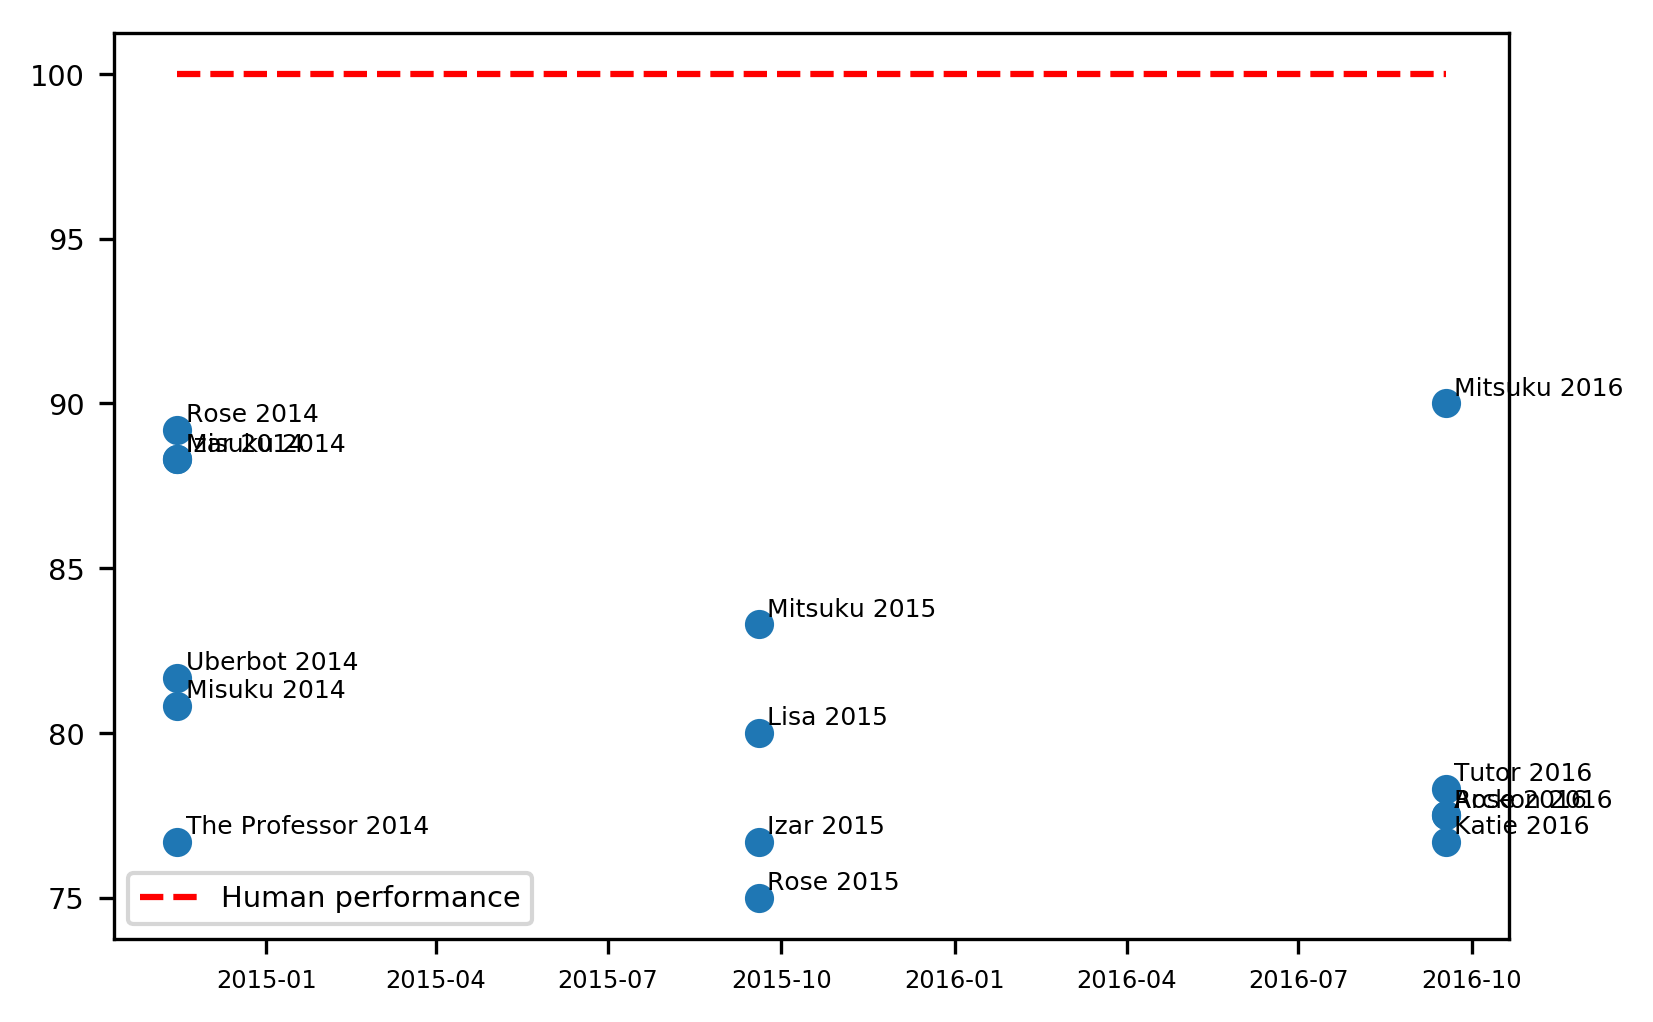

Treebank Perplexity (6 measurements)


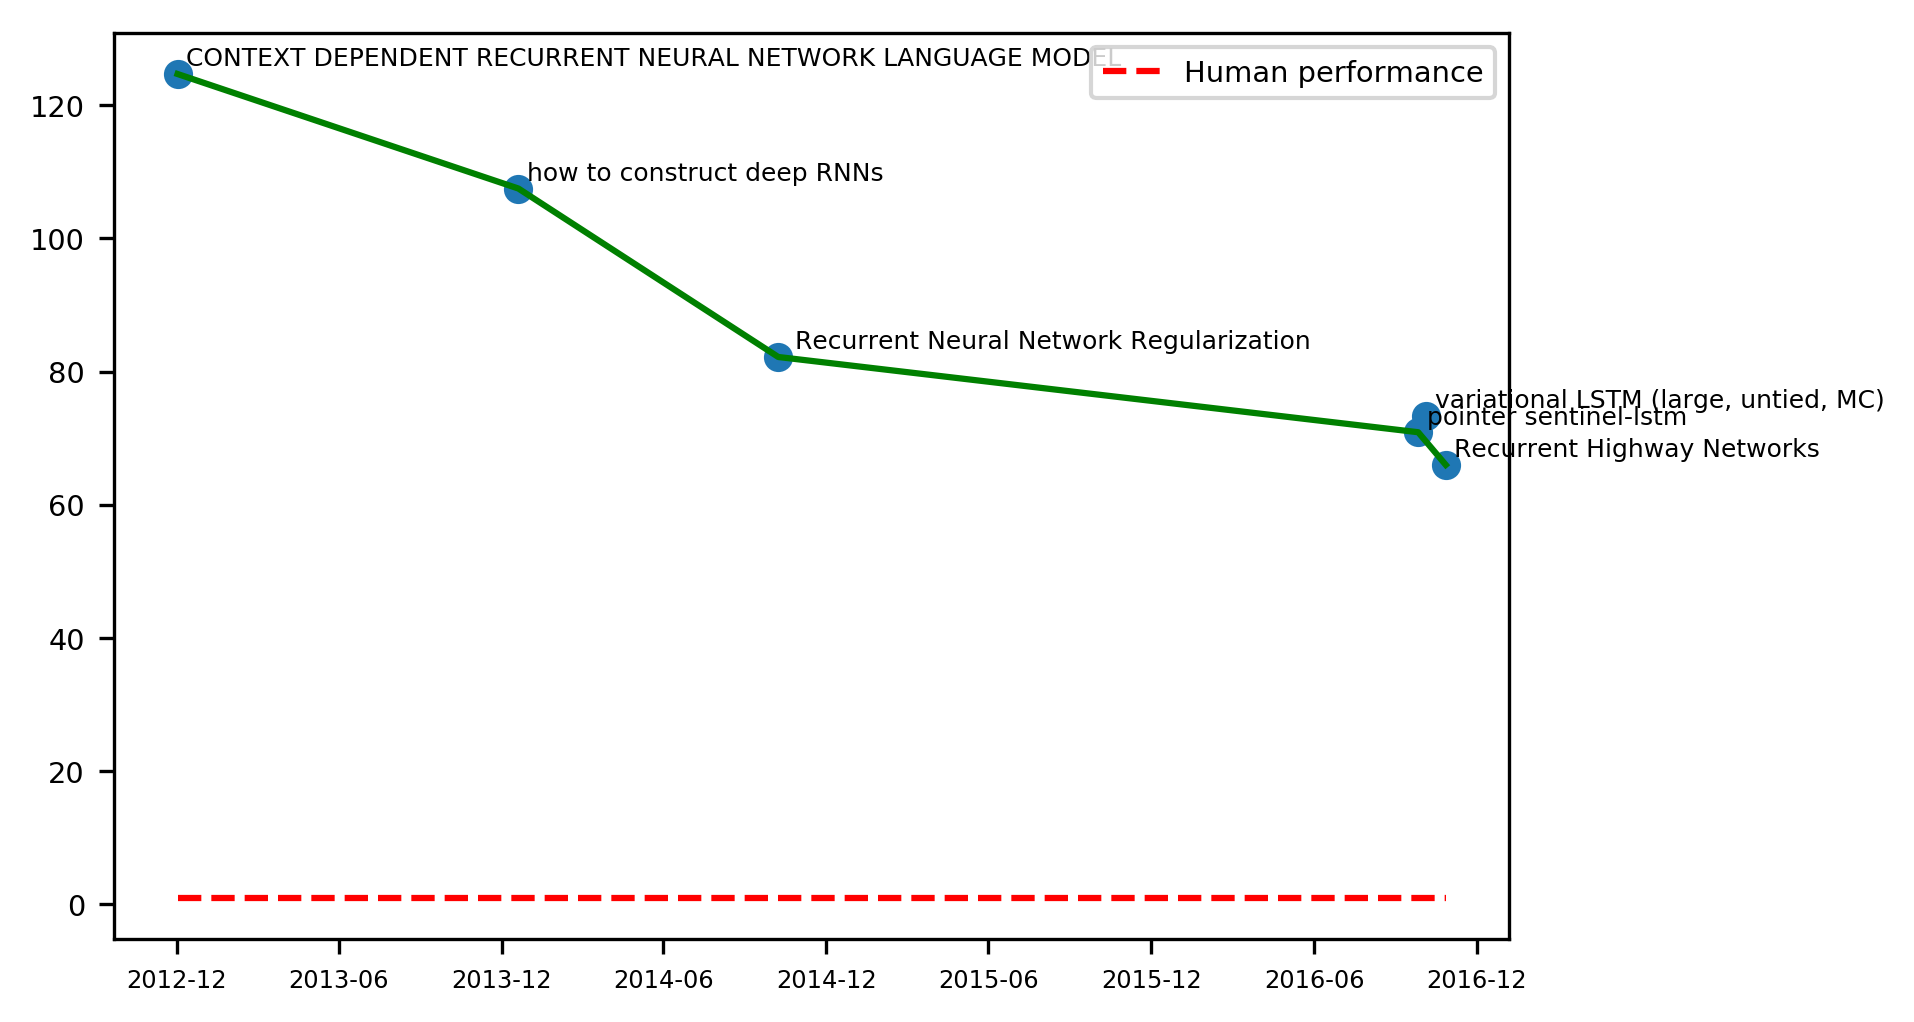

bAbi (8 measurements)


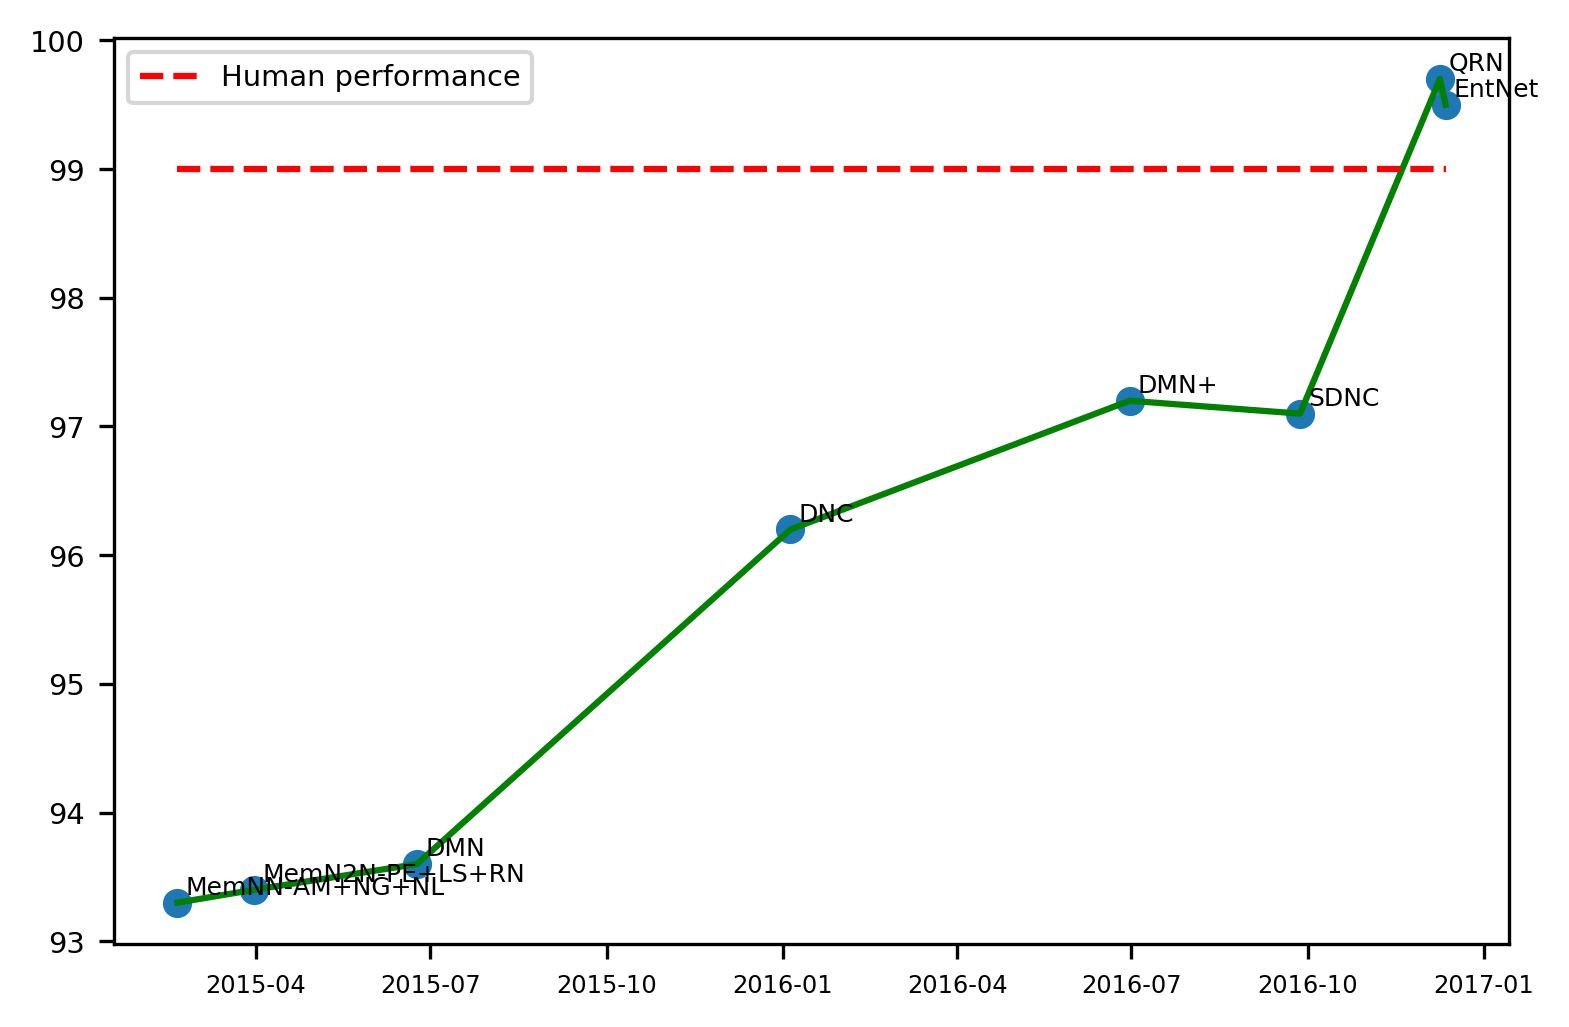

hutter prize bits-per-character (9 measurements)


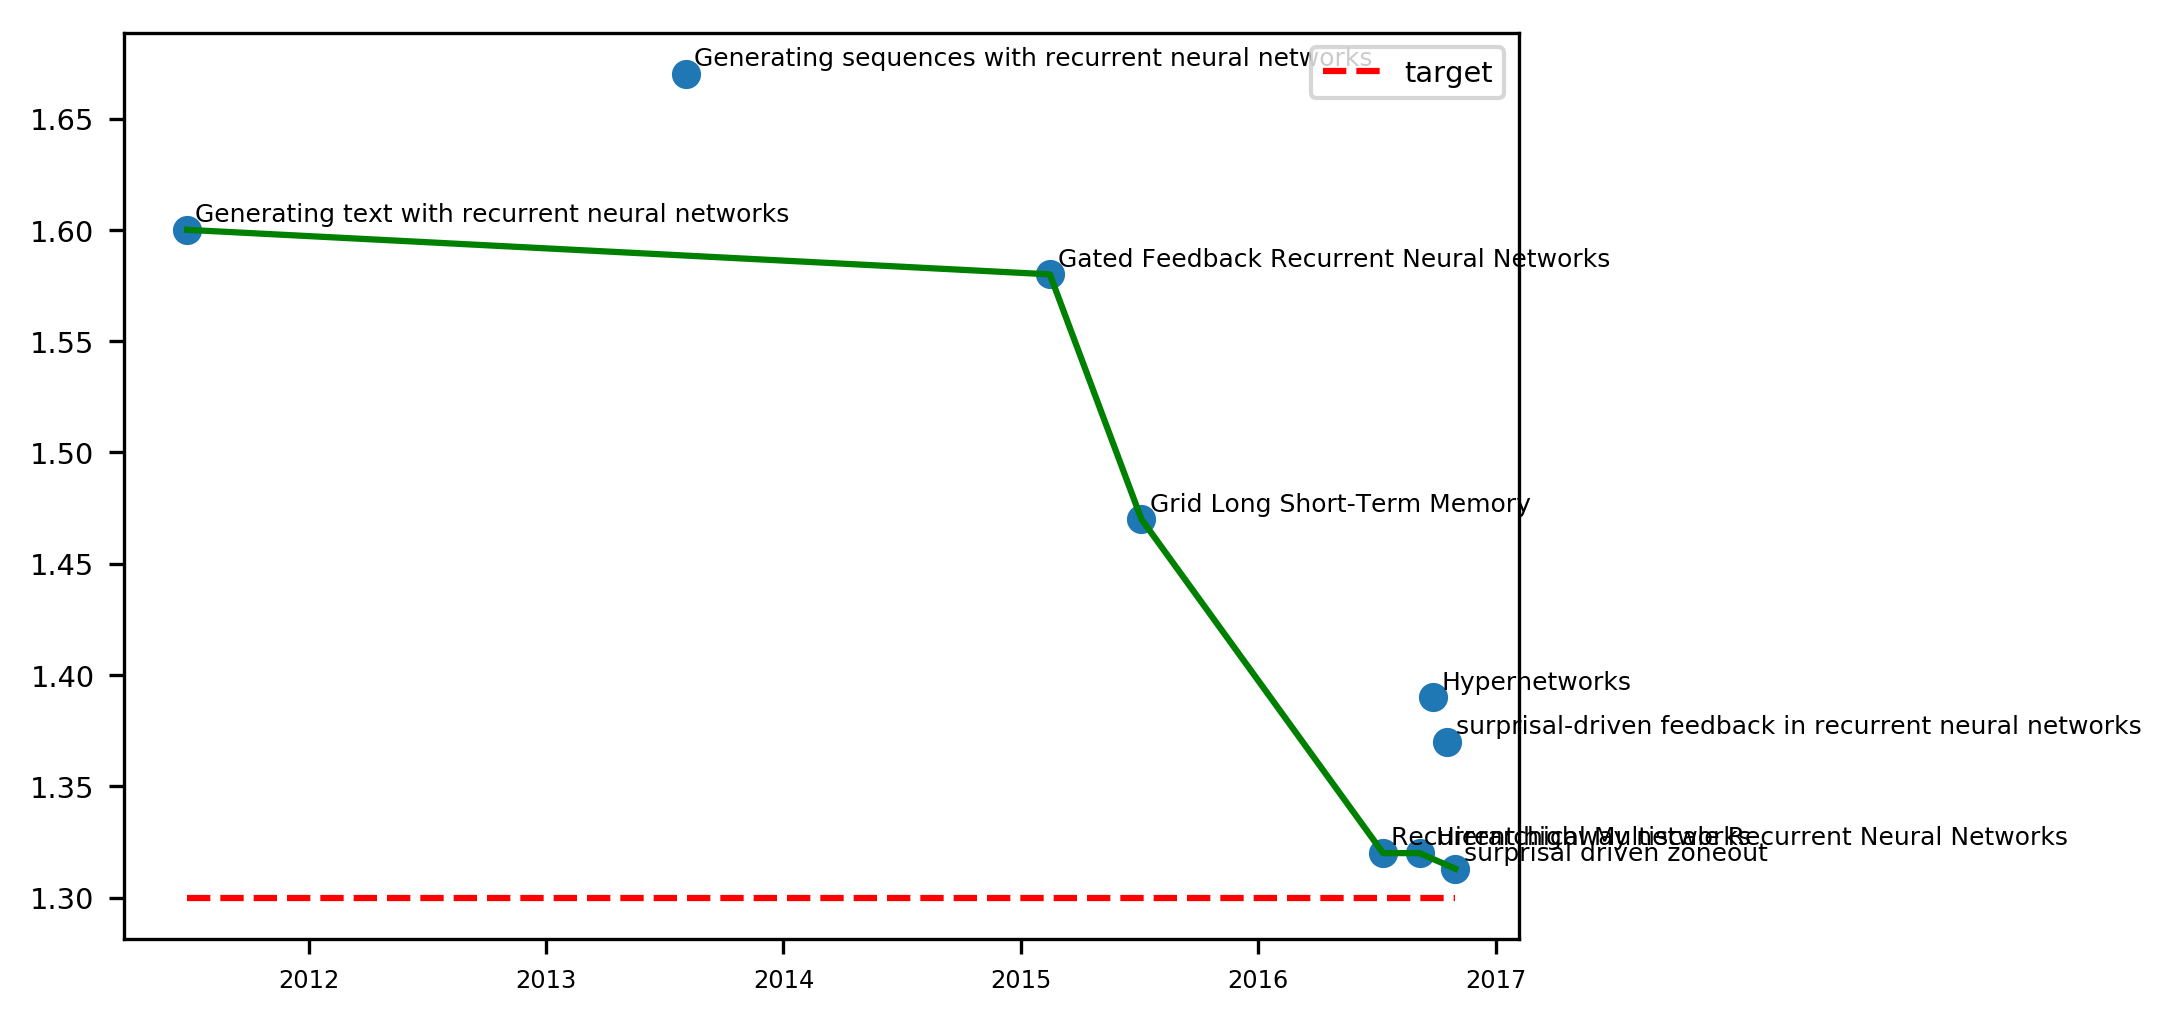

bits-per-subpixel (6 measurements)


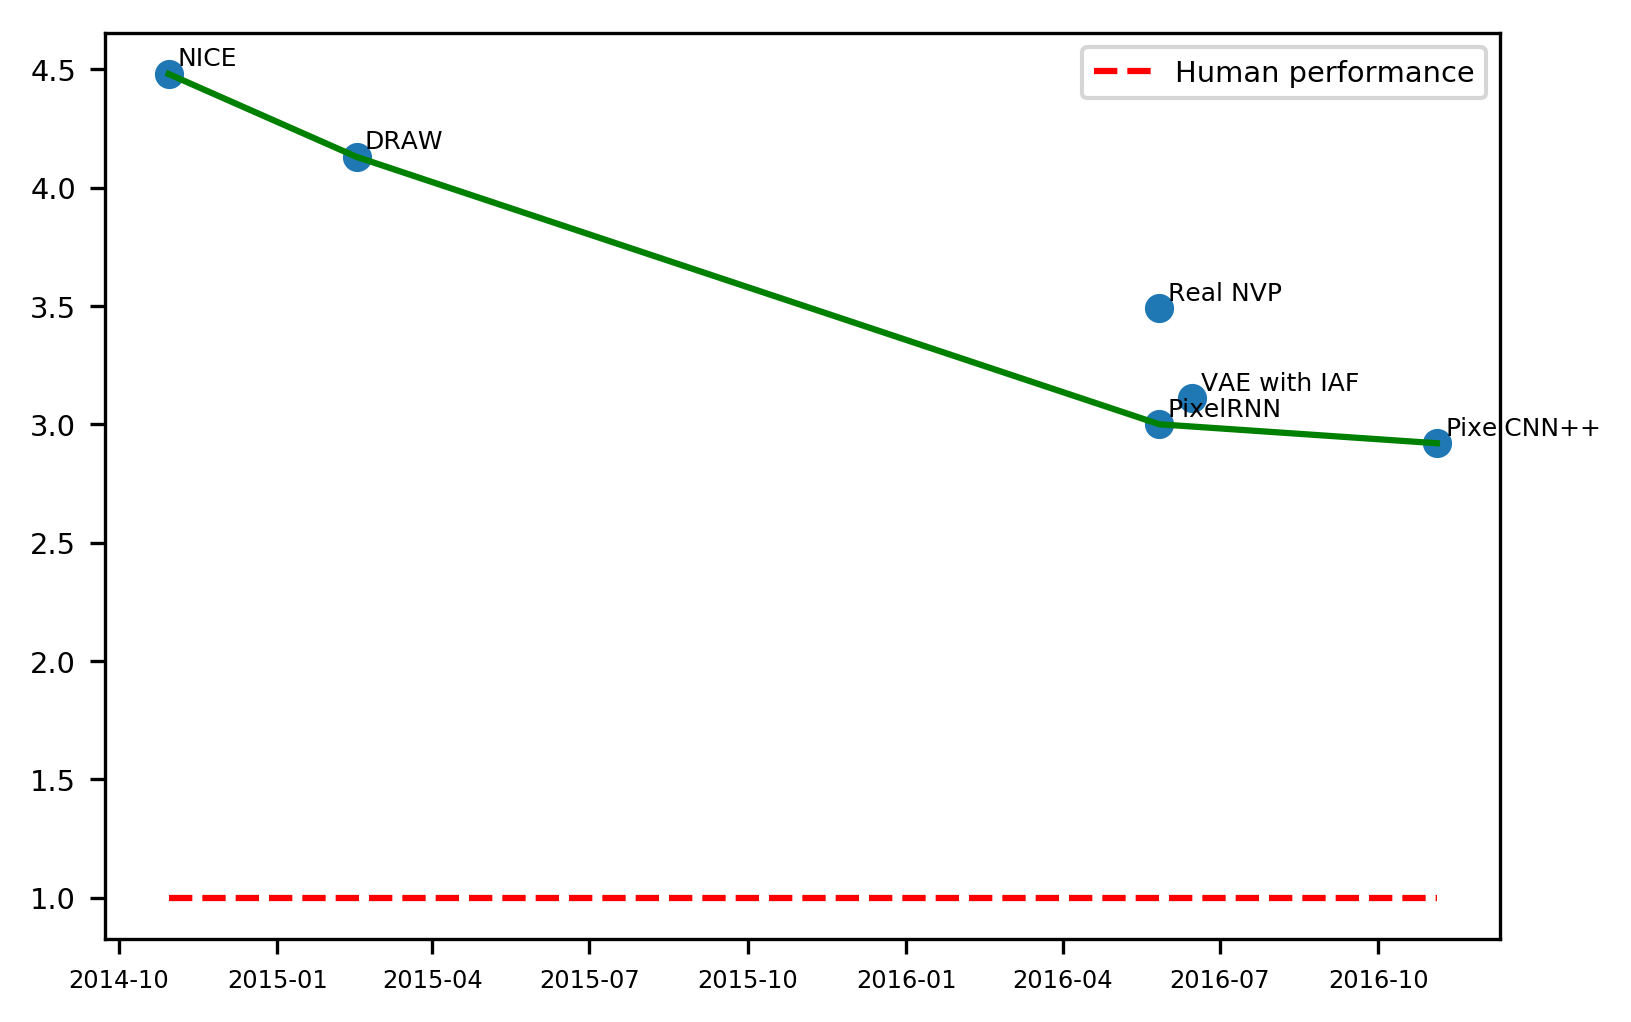

Breakout (5 measurements)


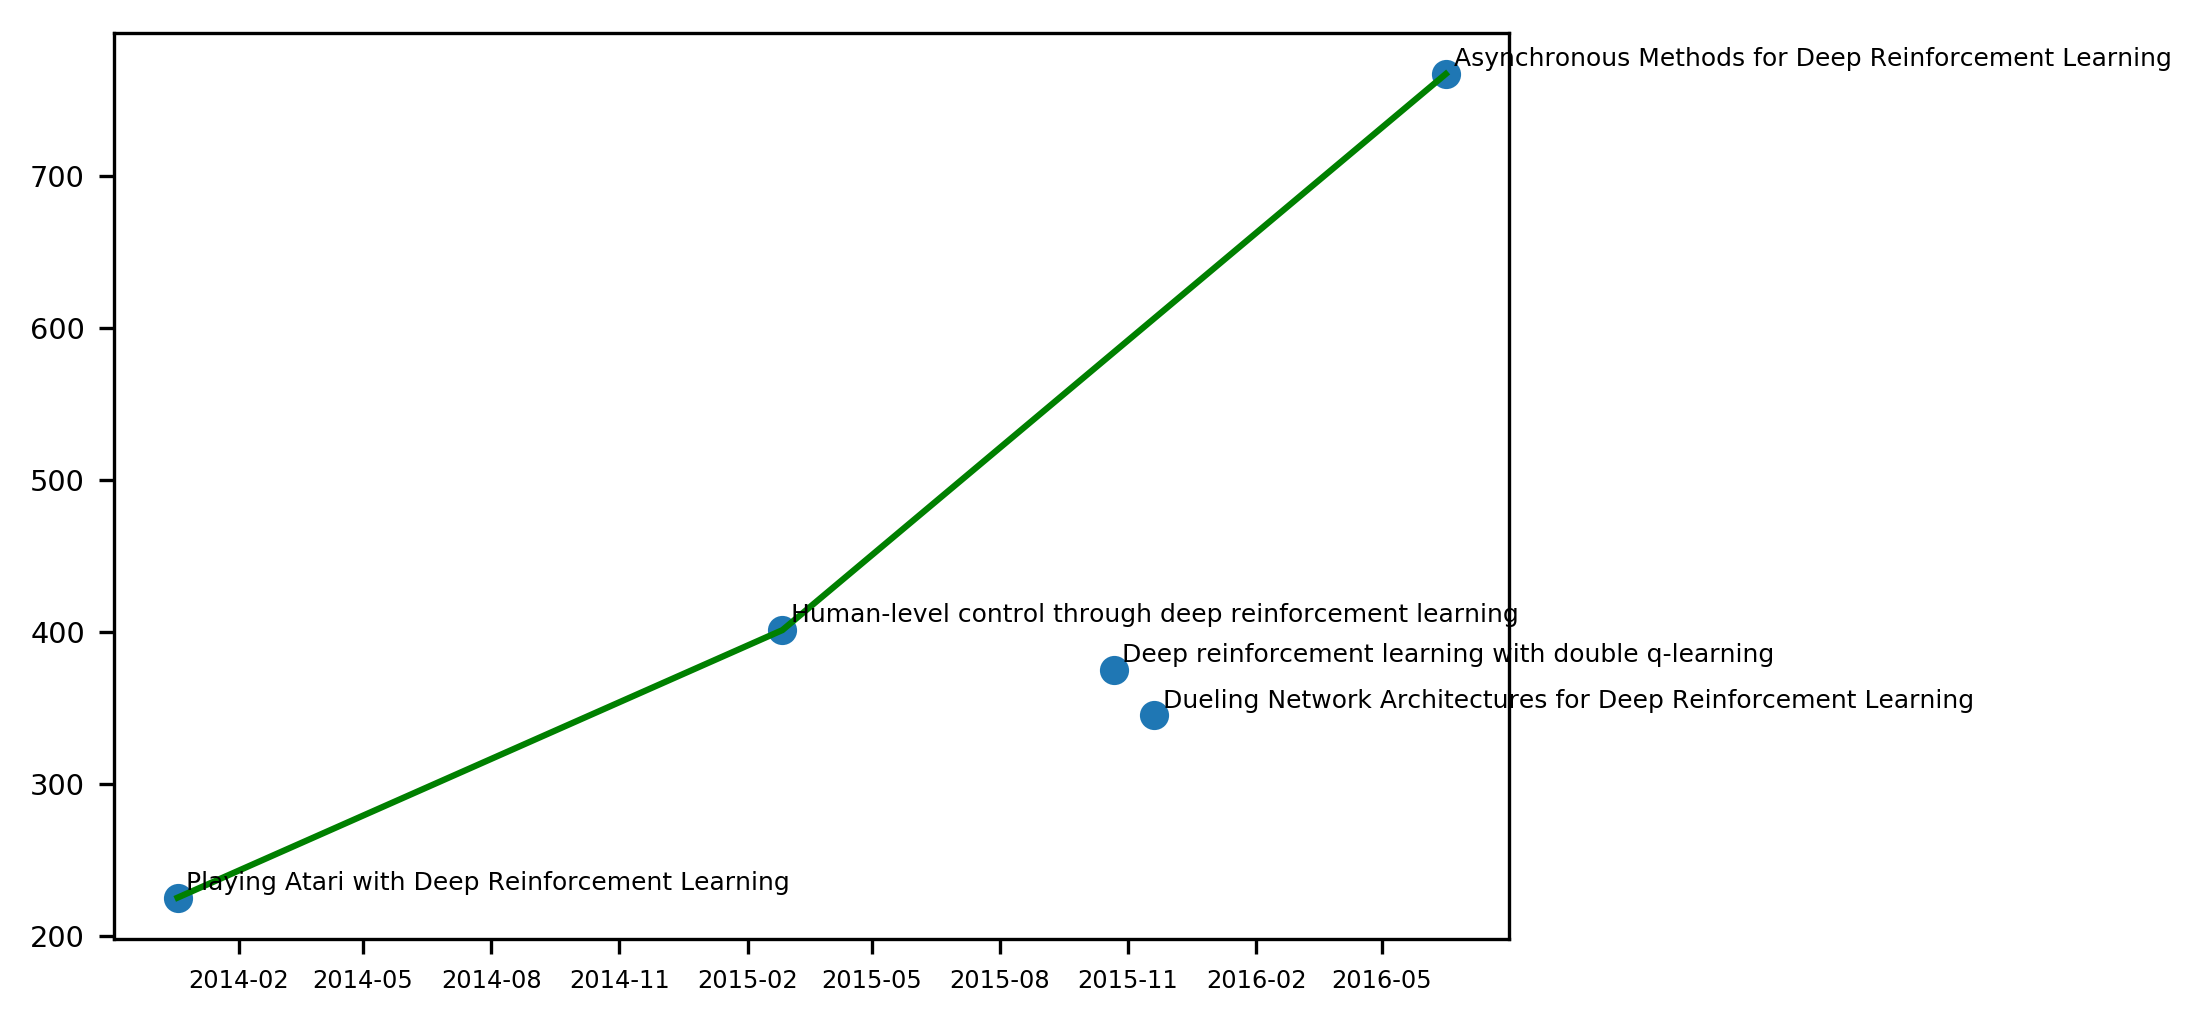

Word error rate on Switchboard (12 measurements)


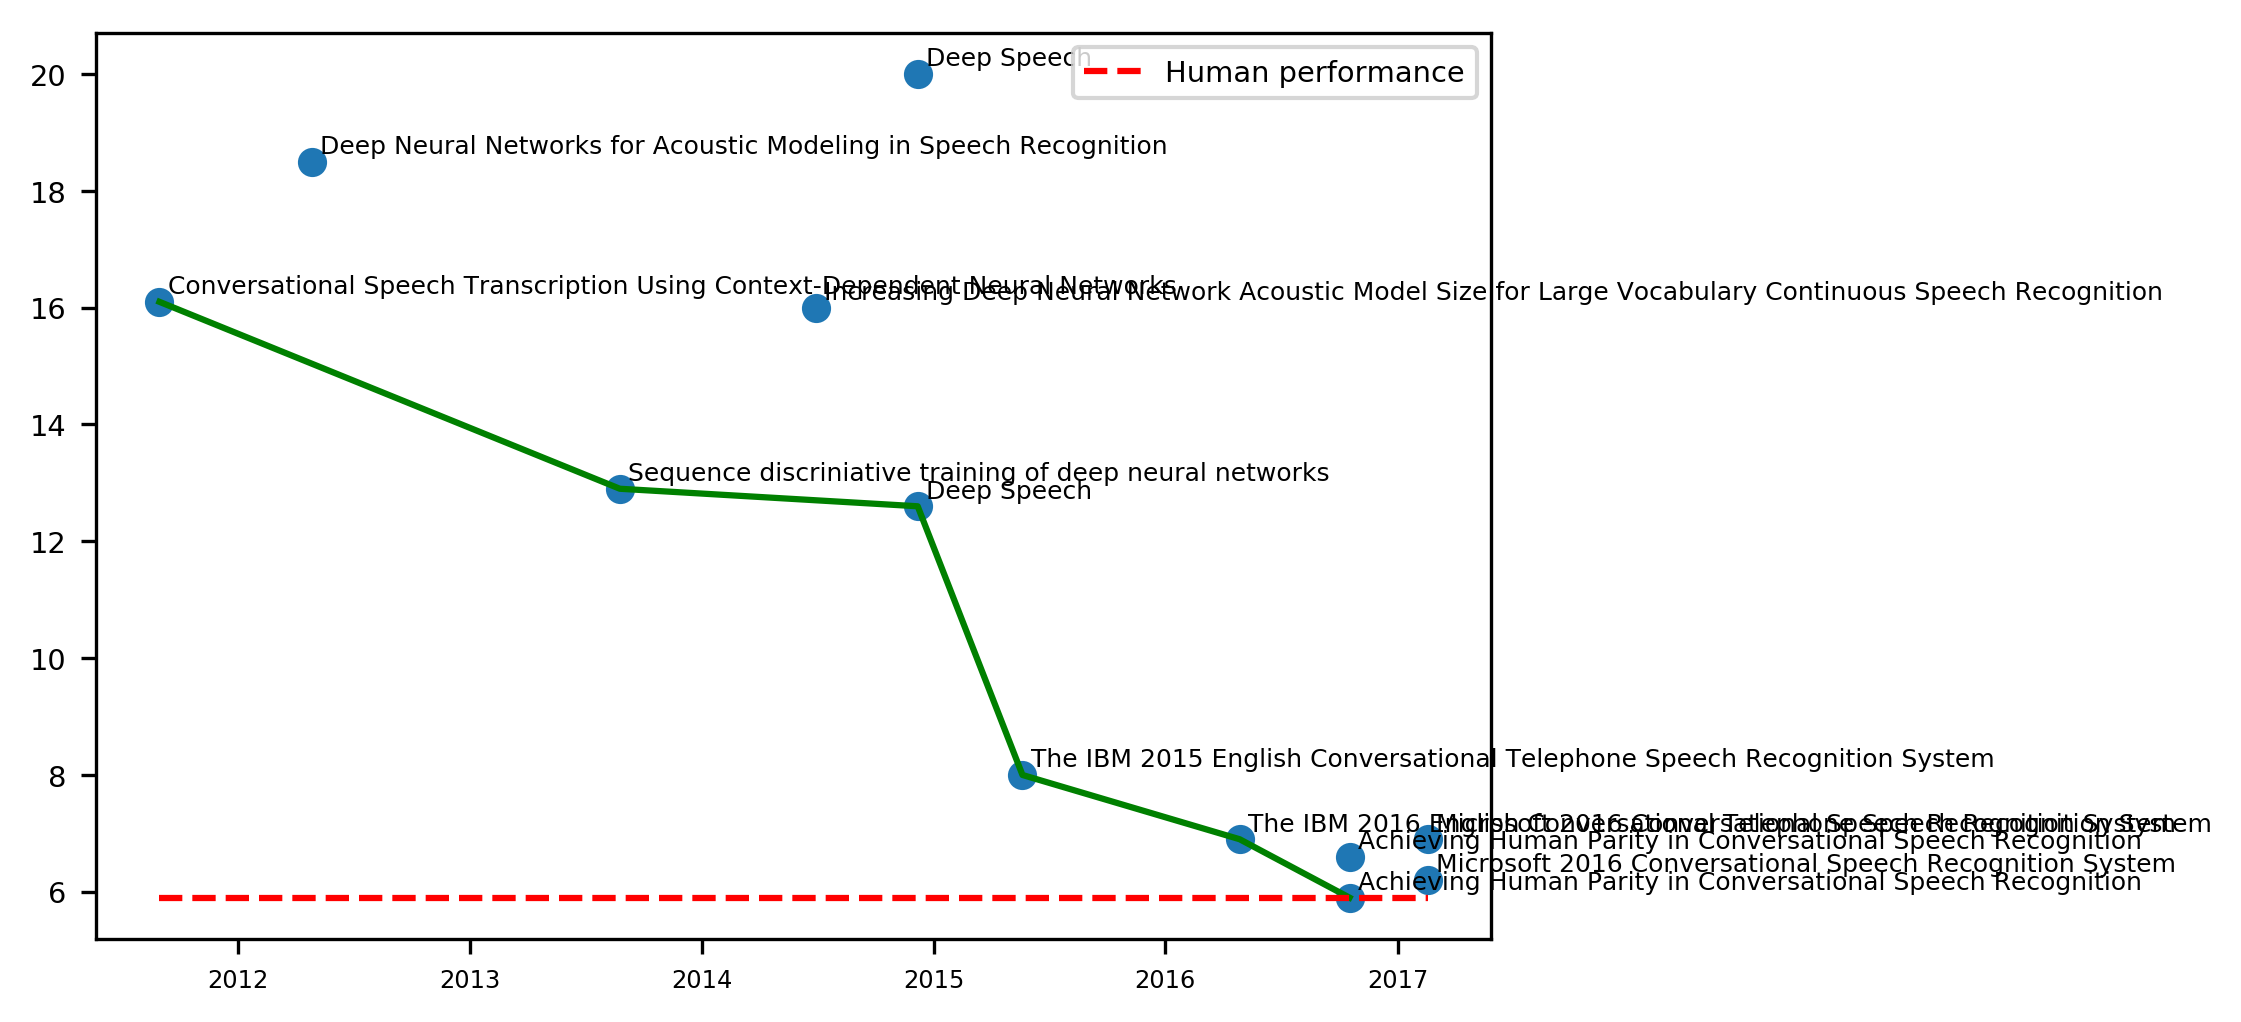

imagenet (7 measurements)


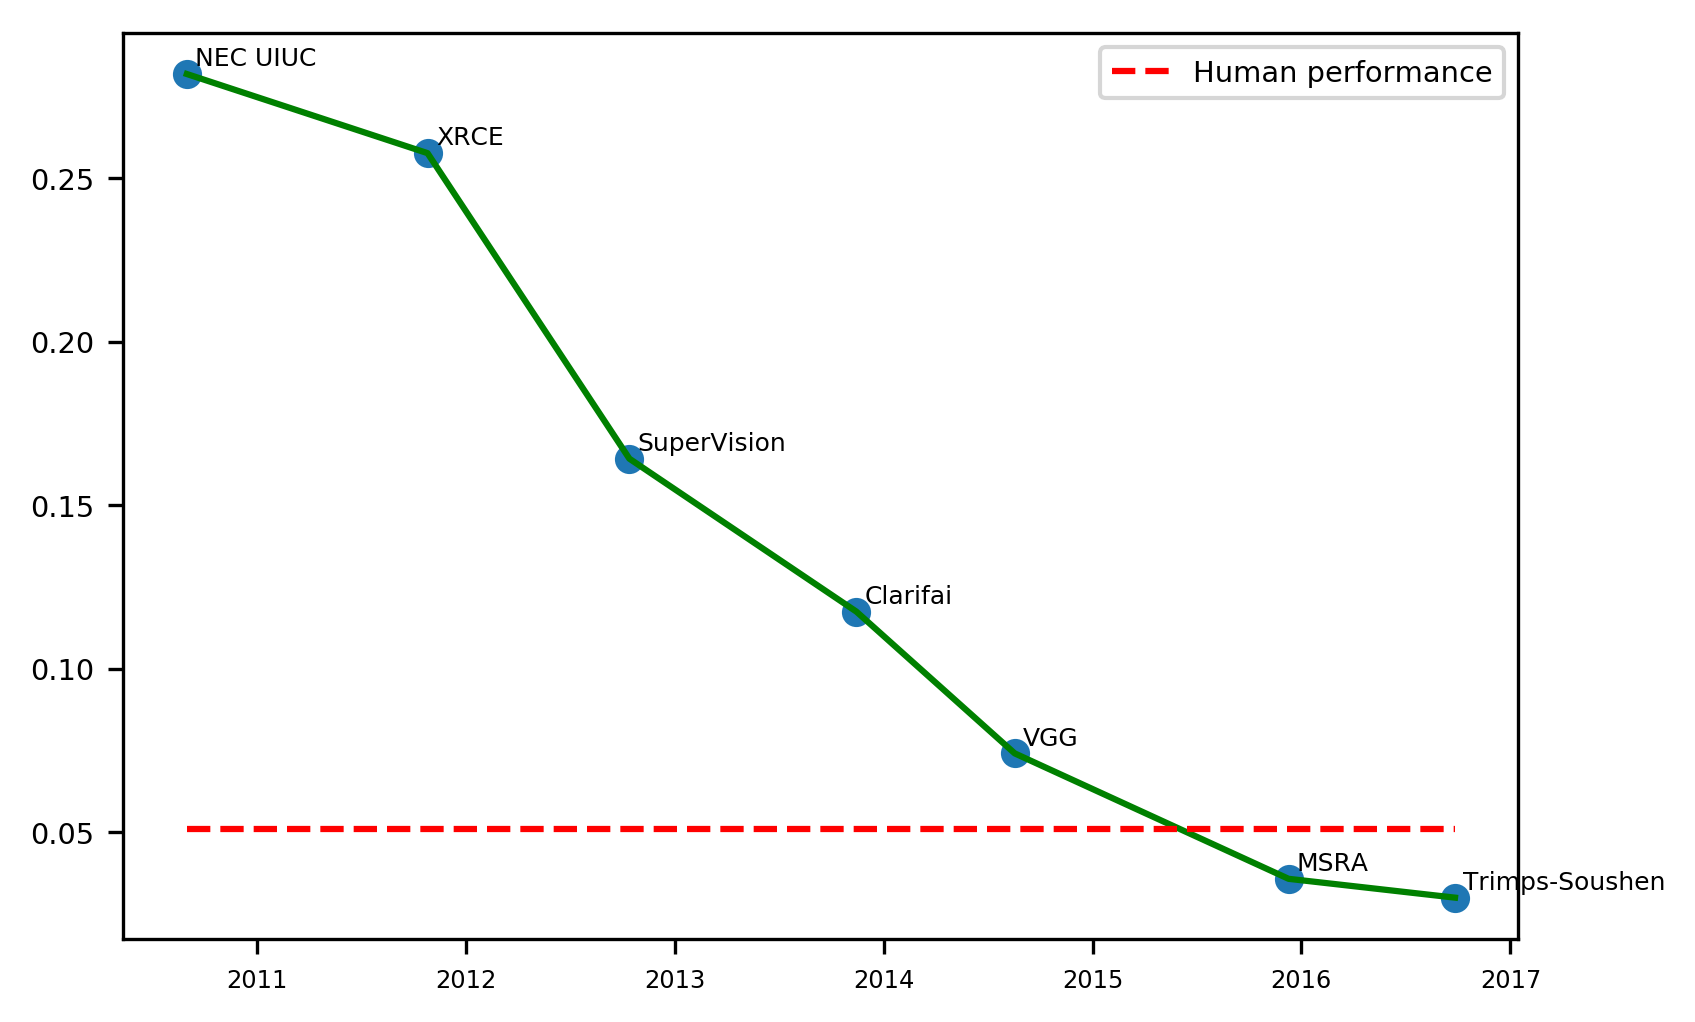

Pong (5 measurements)


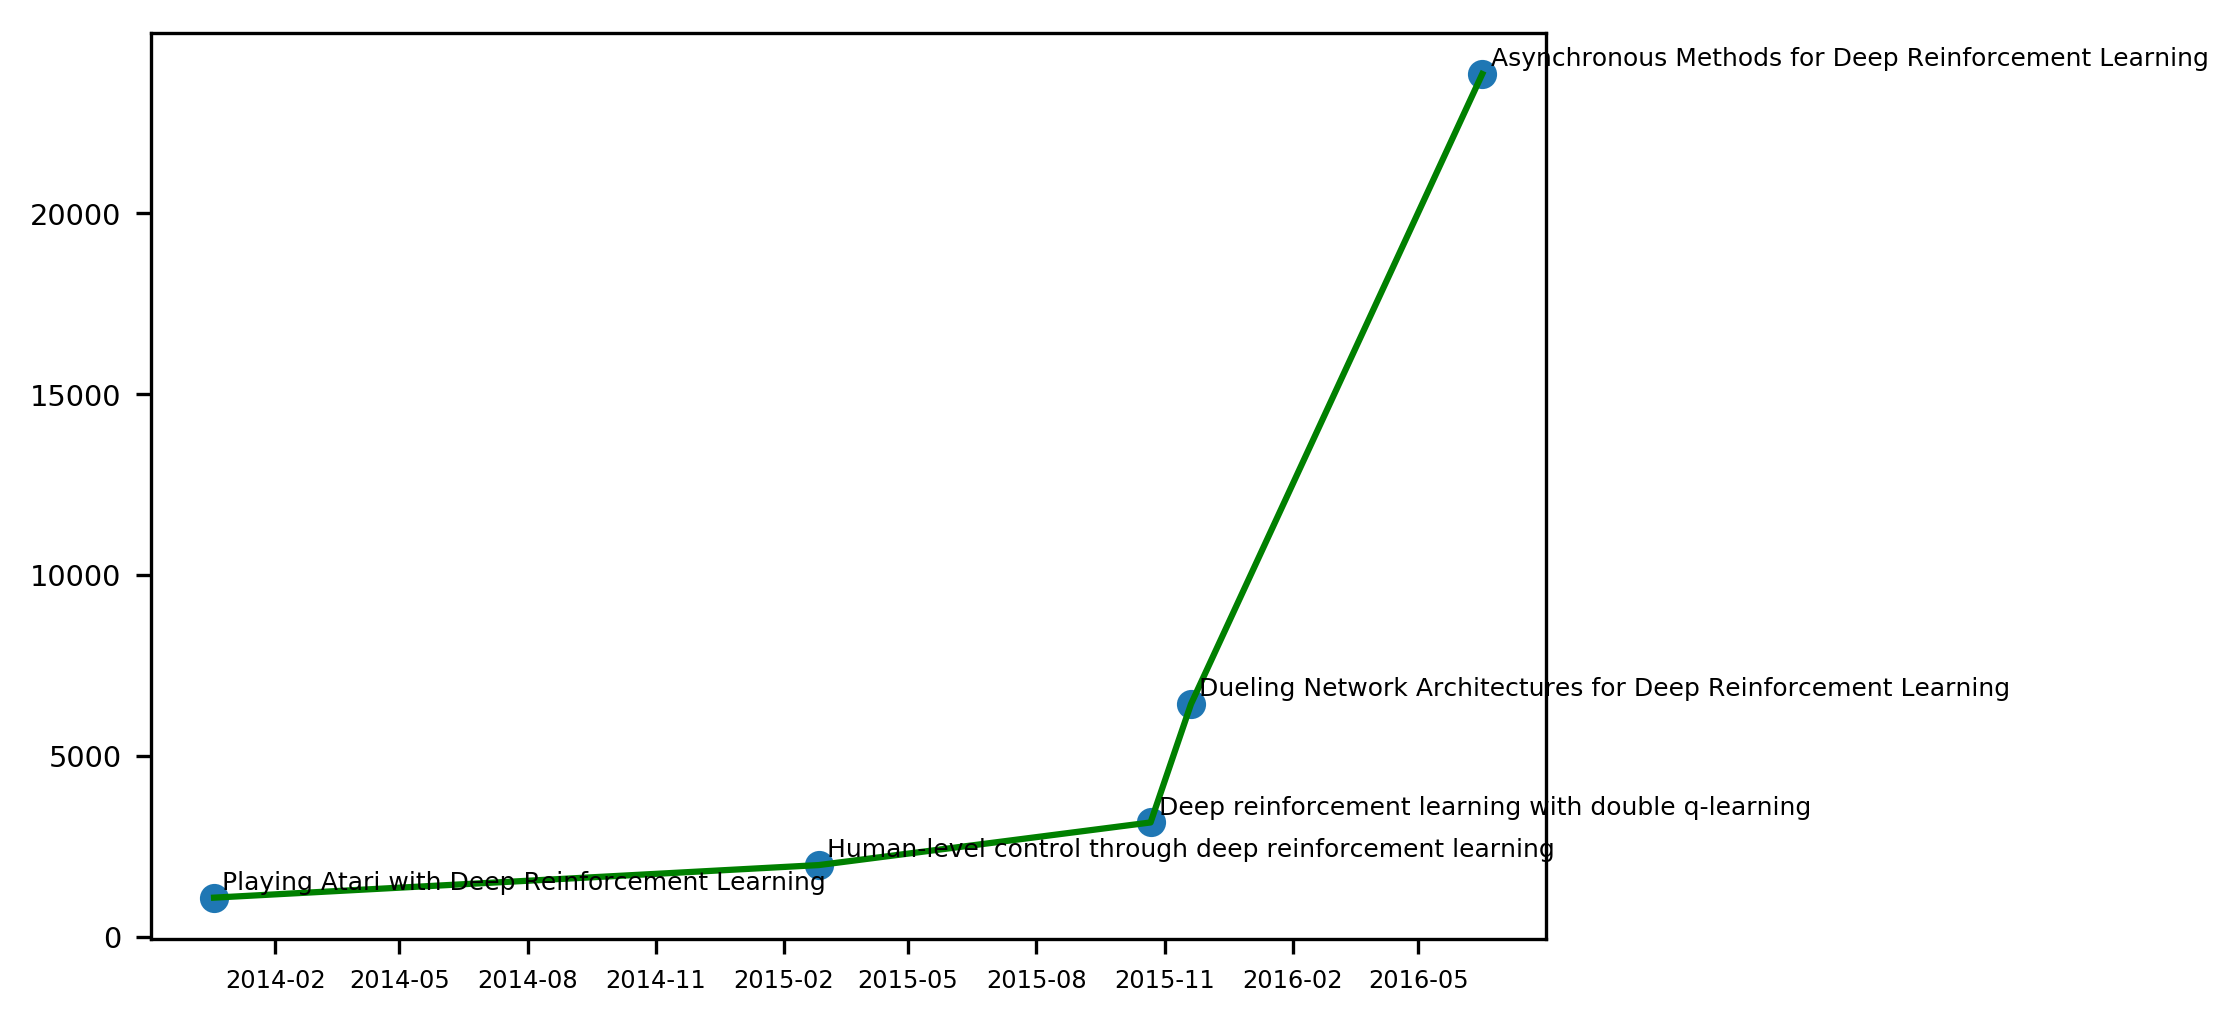

Enduro (5 measurements)


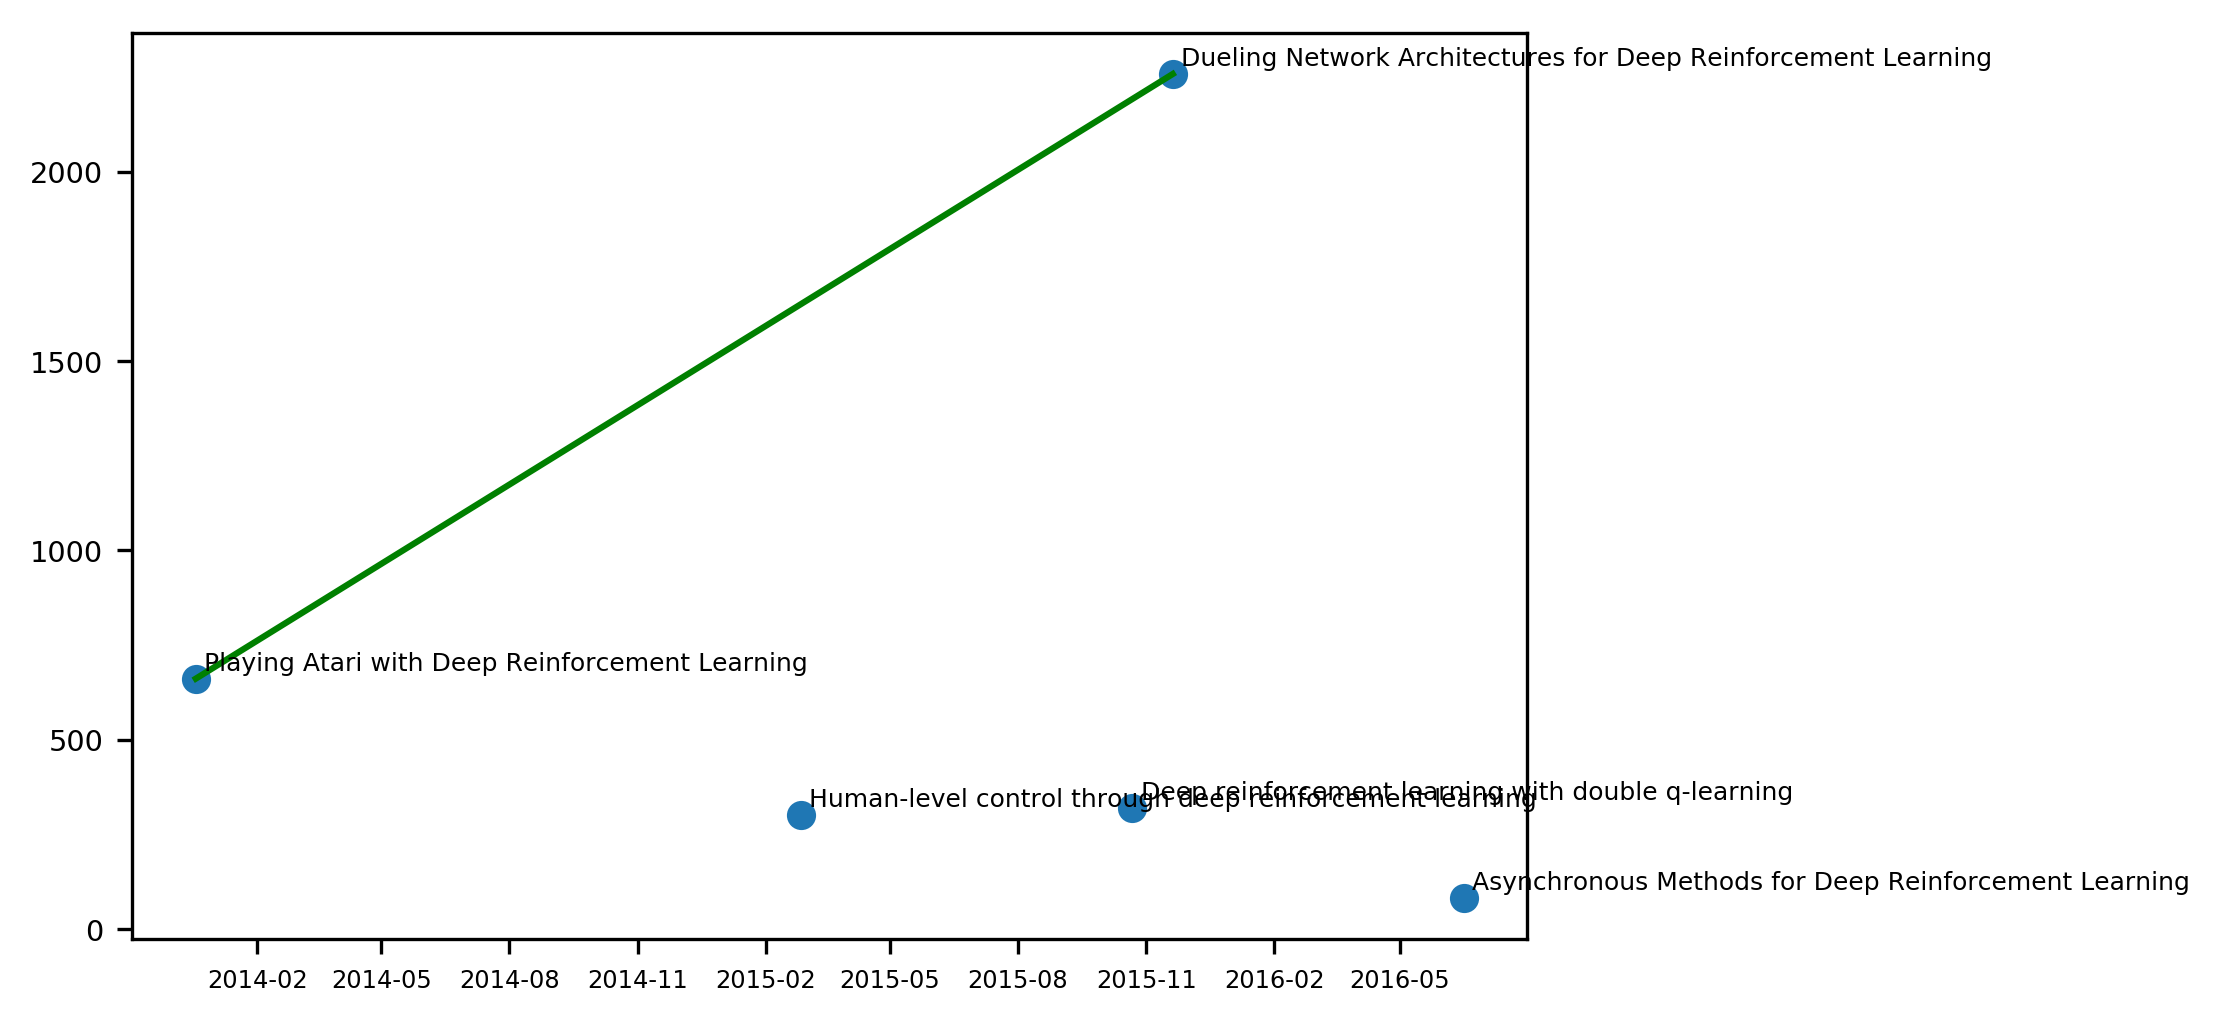

learning chess (0 measurements)
mastering chess (0 measurements)
learning go (0 measurements)


In [387]:
def graphs():
    print "Graphs of progress:"
    for name, metric in metrics.items():
        print name, "({0} measurements)".format(len(metric.measures))
        if len(metric.measures) > 2:
            metric.graph()
    plt.show()
            
    
        
graphs()

# Measurements

Included thus far:
27 problems
14 metrics 5 solved
95 measurements
14 problems which do not yet have any metrics (either not in this notebook, or none in the open literature)

Problems by Type:
agi 16 solved: 2
language 6 solved: 2
curiosity 1 solved: 0
communication 2 solved: 0
world-modelling 6 solved: 1
safety 5 solved: 0
compression 1 solved: 0
abstract-games 5 solved: 1
super 1 solved: 0
vision 4 solved: 0
realtime-games 1 solved: 0

Sample of problems characterized thus far:


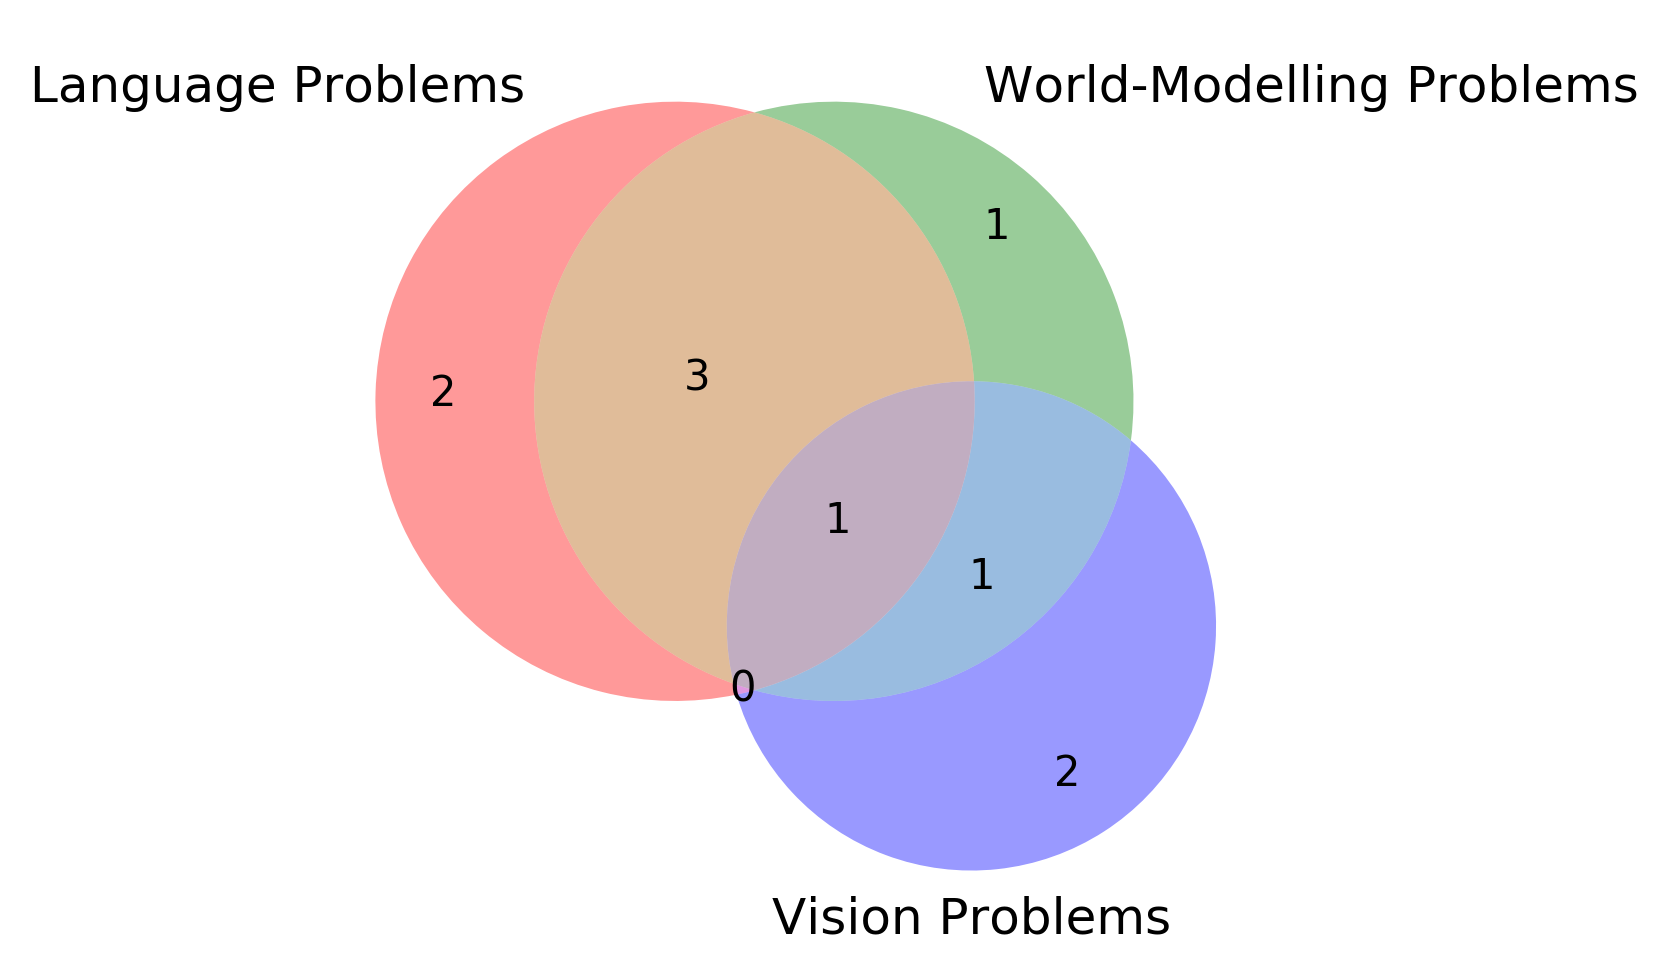

In [388]:
counts()
venn_report()